In [95]:
import pandas as pd
import seaborn as sn
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

plt.style.use('ggplot')

In [96]:
explanation = pd.read_csv(
    filepath_or_buffer='dataset/vg_data_dictionary.csv'
)

df = pd.read_csv(
    filepath_or_buffer='dataset/vgchartz-2024.csv',
    engine='pyarrow',
    dtype_backend='pyarrow' # Better memory efficiency and speed, 
                            # especially for strings and missing values. 

)

In [97]:
# We can extract the meanings of fields by inspecting dataset on dictionary
explanation.head(n=10)

Field                                 Description
0           img    URL slug for the box art at vgchartz.com
1         title                                  Game title
2       console           Console the game was released for
3         genre                           Genre of the game
4     publisher                       Publisher of the game
5     developer                       Developer of the game
6  critic_score                Metacritic score (out of 10)
7   total_sales          Global sales of copies in millions
8      na_sales  North American sales of copies in millions
9      jp_sales        Japanese sales of copies in millions

In [99]:
# It is highly likely that we are not going to work with image, 
# so I am dropping this column. 
df = df.drop(columns='img', axis=1)

# Furthermore, it seems that we also are not going to with `last_update` column.
# Thus, I am droppping it either.
df = df.drop(columns='last_update', axis=1) 

In [100]:
# Converting dates to datetime.
df['release_date'] = pd.to_datetime(df['release_date'])

In [101]:
# Detecting the number of NaN values per column. 
# Kind reminder: I am not going to do anything regarding handling NaN values.
df.isnull().sum()

title               0
console             0
genre               0
publisher           0
developer          17
critic_score    57338
total_sales     45094
na_sales        51379
jp_sales        57290
pal_sales       51192
other_sales     48888
release_date     7051
dtype: int64

In [102]:
# Brief info on resulting dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   title         64016 non-null  string[pyarrow]
 1   console       64016 non-null  string[pyarrow]
 2   genre         64016 non-null  string[pyarrow]
 3   publisher     64016 non-null  string[pyarrow]
 4   developer     63999 non-null  string[pyarrow]
 5   critic_score  6678 non-null   double[pyarrow]
 6   total_sales   18922 non-null  double[pyarrow]
 7   na_sales      12637 non-null  double[pyarrow]
 8   jp_sales      6726 non-null   double[pyarrow]
 9   pal_sales     12824 non-null  double[pyarrow]
 10  other_sales   15128 non-null  double[pyarrow]
 11  release_date  56965 non-null  datetime64[ns] 
dtypes: datetime64[ns](1), double[pyarrow](6), string[pyarrow](5)
memory usage: 8.1 MB


## Analysis

### Total Worldwide Sales

In [103]:
# Finding the total worldwide sales (`total_sales`) 
# for all games in the dataset.
worldwide_sales = df['total_sales'].sum()
print(f"Total sum of sales in millions: {np.round(worldwide_sales)}")

Total sum of sales in millions: 6606.0


### Total sales of Role-Playing Games in Japan

In [104]:
# Calculating the total sales in Japan (jp_sales) 
# only for games in the 'Role-Playing' genre.
total_sales_in_rp_japan = df[df['genre'] == 'Role-Playing']['jp_sales'].sum()
print(f'The Total sales of Role-Playing games in Japan: {np.round(total_sales_in_rp_japan)}')

The Total sales of Role-Playing games in Japan: 131.0


### Average Critic Score Per Game

In [105]:
# Calculating the average critic score (`critic_score`) for all games. 
# NaN values will be excluded from the result.

avg_critic_score = df.groupby('title') \
                     .agg({'critic_score': 'mean'}) \
                     .dropna() \
                     .sort_values(by='critic_score', ascending=False)

# Round values up to 2 decimals - it will make easier to understand the table.
avg_critic_score['critic_score'] = np.round(avg_critic_score['critic_score'], 2)

In [106]:
avg_critic_score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4718 entries, Final Fantasy II to Kabuki Warriors
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   critic_score  4718 non-null   double[pyarrow]
dtypes: double[pyarrow](1)
memory usage: 155.1 KB


In [107]:
# 4718 would be way too much for horizontal bar chart. 
# I have decided to randomly pick 20 titles and 
# plot horizontal bar char using only them. 
our_data = avg_critic_score.sample(20) \
                           .sort_values(by='critic_score', ascending=True)

In [108]:
titles = our_data.index.to_list()
scores = our_data['critic_score'].to_list()

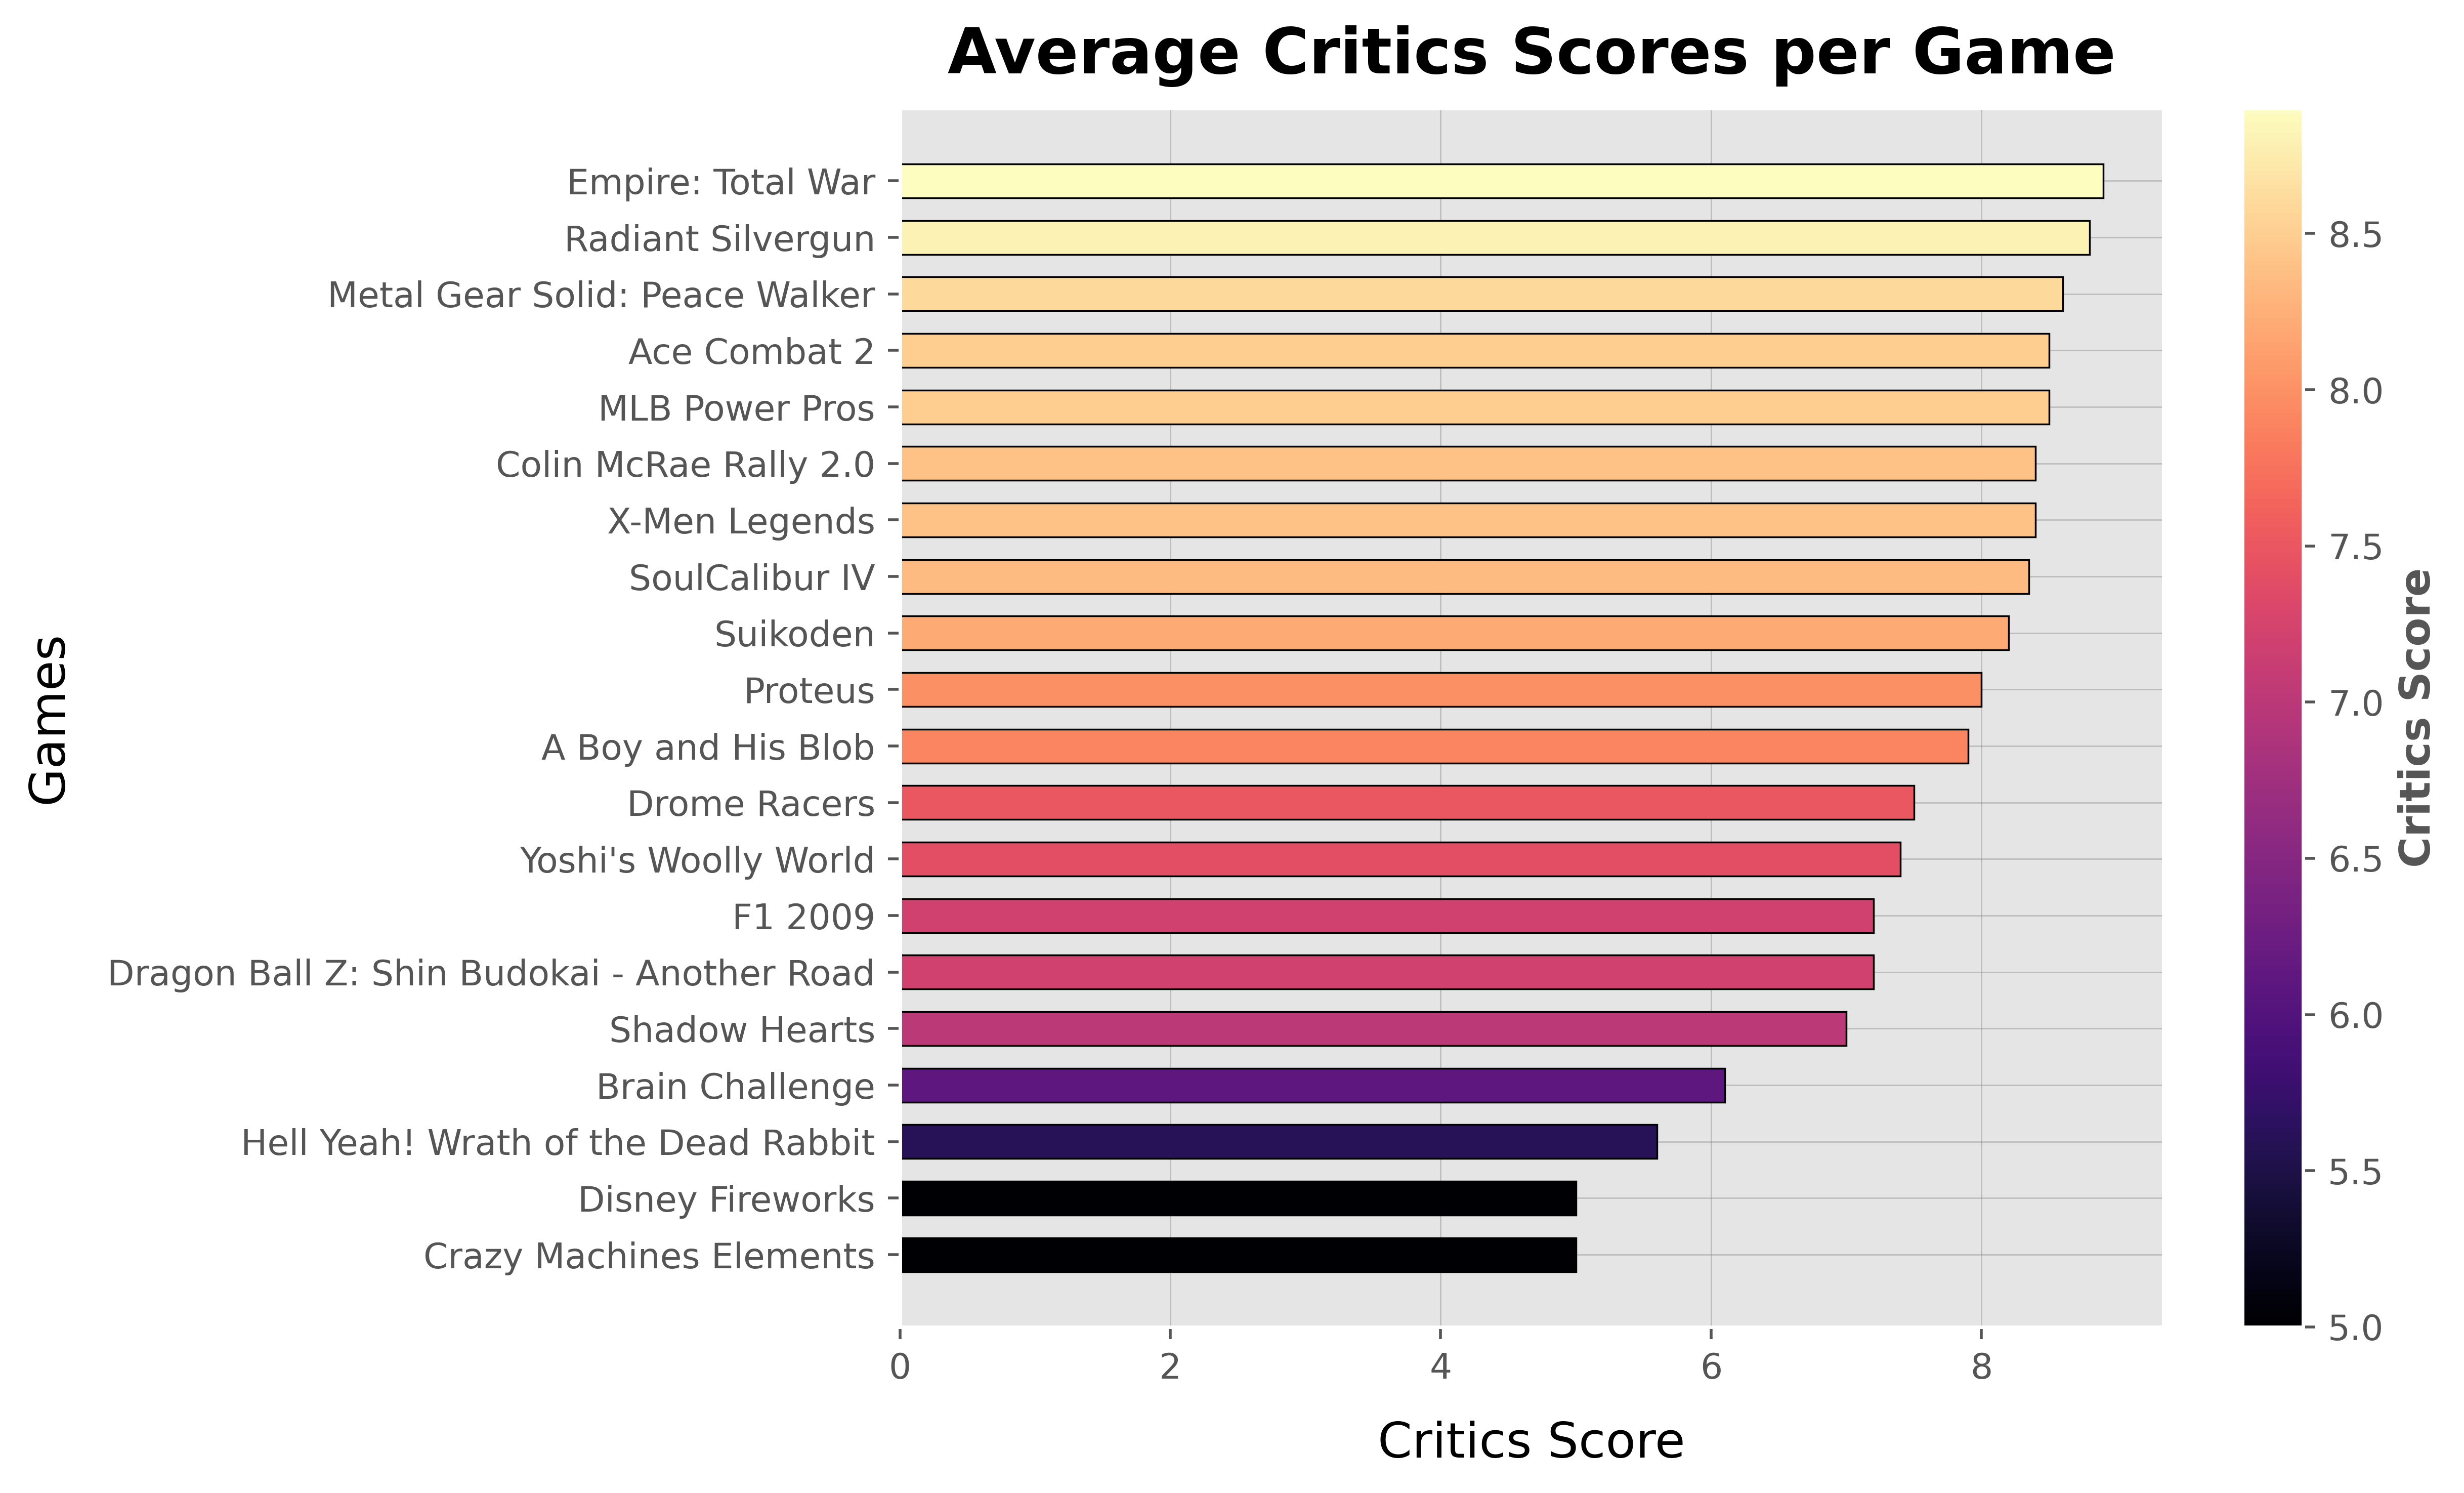

In [109]:
# Normalizing the data for colormap (0 to 1)
norm = mcolors.Normalize(
    vmin=our_data['critic_score'].min(),
    vmax=our_data['critic_score'].max()
)
cmap = plt.cm.magma
colors = cmap(norm(our_data['critic_score']))

fig, ax = plt.subplots(
    figsize=(10, 6),
    dpi=500,
)

ax.barh(
    y=our_data.index,
    width=our_data['critic_score'],
    height=0.6,
    color=colors,
    edgecolor='black'
)

ax.set_title(
    label='Average Critics Scores per Game',
    fontsize=18,
    fontweight='bold',
    color='black',
    loc='center',
    pad=10
)

ax.set_xlabel(
    xlabel='Critics Score',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.set_ylabel(
    ylabel='Games',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.grid(
    visible=True,
    which='major',
    axis='both',
    color='gray',
    linestyle='-',
    linewidth=0.4,
    alpha=0.4
)

# Adding colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(
    label='Critics Score',
    fontsize=12,
    fontweight='bold'
)

plt.tight_layout()
plt.show()

### Best Possible Critics Score

In [110]:
# Finding the best possible critic score (`critic_score`) in the entire dataset.
best_sritic_score = df[df['critic_score'] == 10.0]
best_sritic_score.head(3)

title console   genre       publisher  \
16                      Grand Theft Auto IV    X360  Action  Rockstar Games   
19                      Grand Theft Auto IV     PS3  Action  Rockstar Games   
1191  Red Dead Redemption: Undead Nightmare     PS3  Action  Rockstar Games   

               developer  critic_score  total_sales  na_sales  jp_sales  \
16        Rockstar North          10.0        11.09       6.8      0.14   
19        Rockstar North          10.0        10.57      4.79      0.44   
1191  Rockstar San Diego          10.0         1.18      0.47      0.06   

      pal_sales  other_sales release_date  
16         3.11         1.04   2008-04-29  
19         3.73         1.62   2008-04-29  
1191       0.45         0.19   2010-11-23

### Number of Distinct Publishers

In [111]:
# Counting the number of distinct publishers (`publisher`) in the dataset.
disticnt_publisher = df[df['publisher'] != 'Unknown']['publisher'].nunique()
print(f"Total number of distinct publishers: {disticnt_publisher}")

Total number of distinct publishers: 3382


### Games per Genre

In [112]:
# For each genre (genre), how many games there are.
games_per_genre = df.groupby('genre') \
                    .agg({'title': 'count'}) \
                    .sort_values(by='title', ascending=True)

In [113]:
games_per_genre.head()

title
genre            
Sandbox        20
Board Game     33
Education      35
MMO           115
Party         151

In [114]:
genres = games_per_genre.index.to_list()
titles = games_per_genre['title'].to_list()

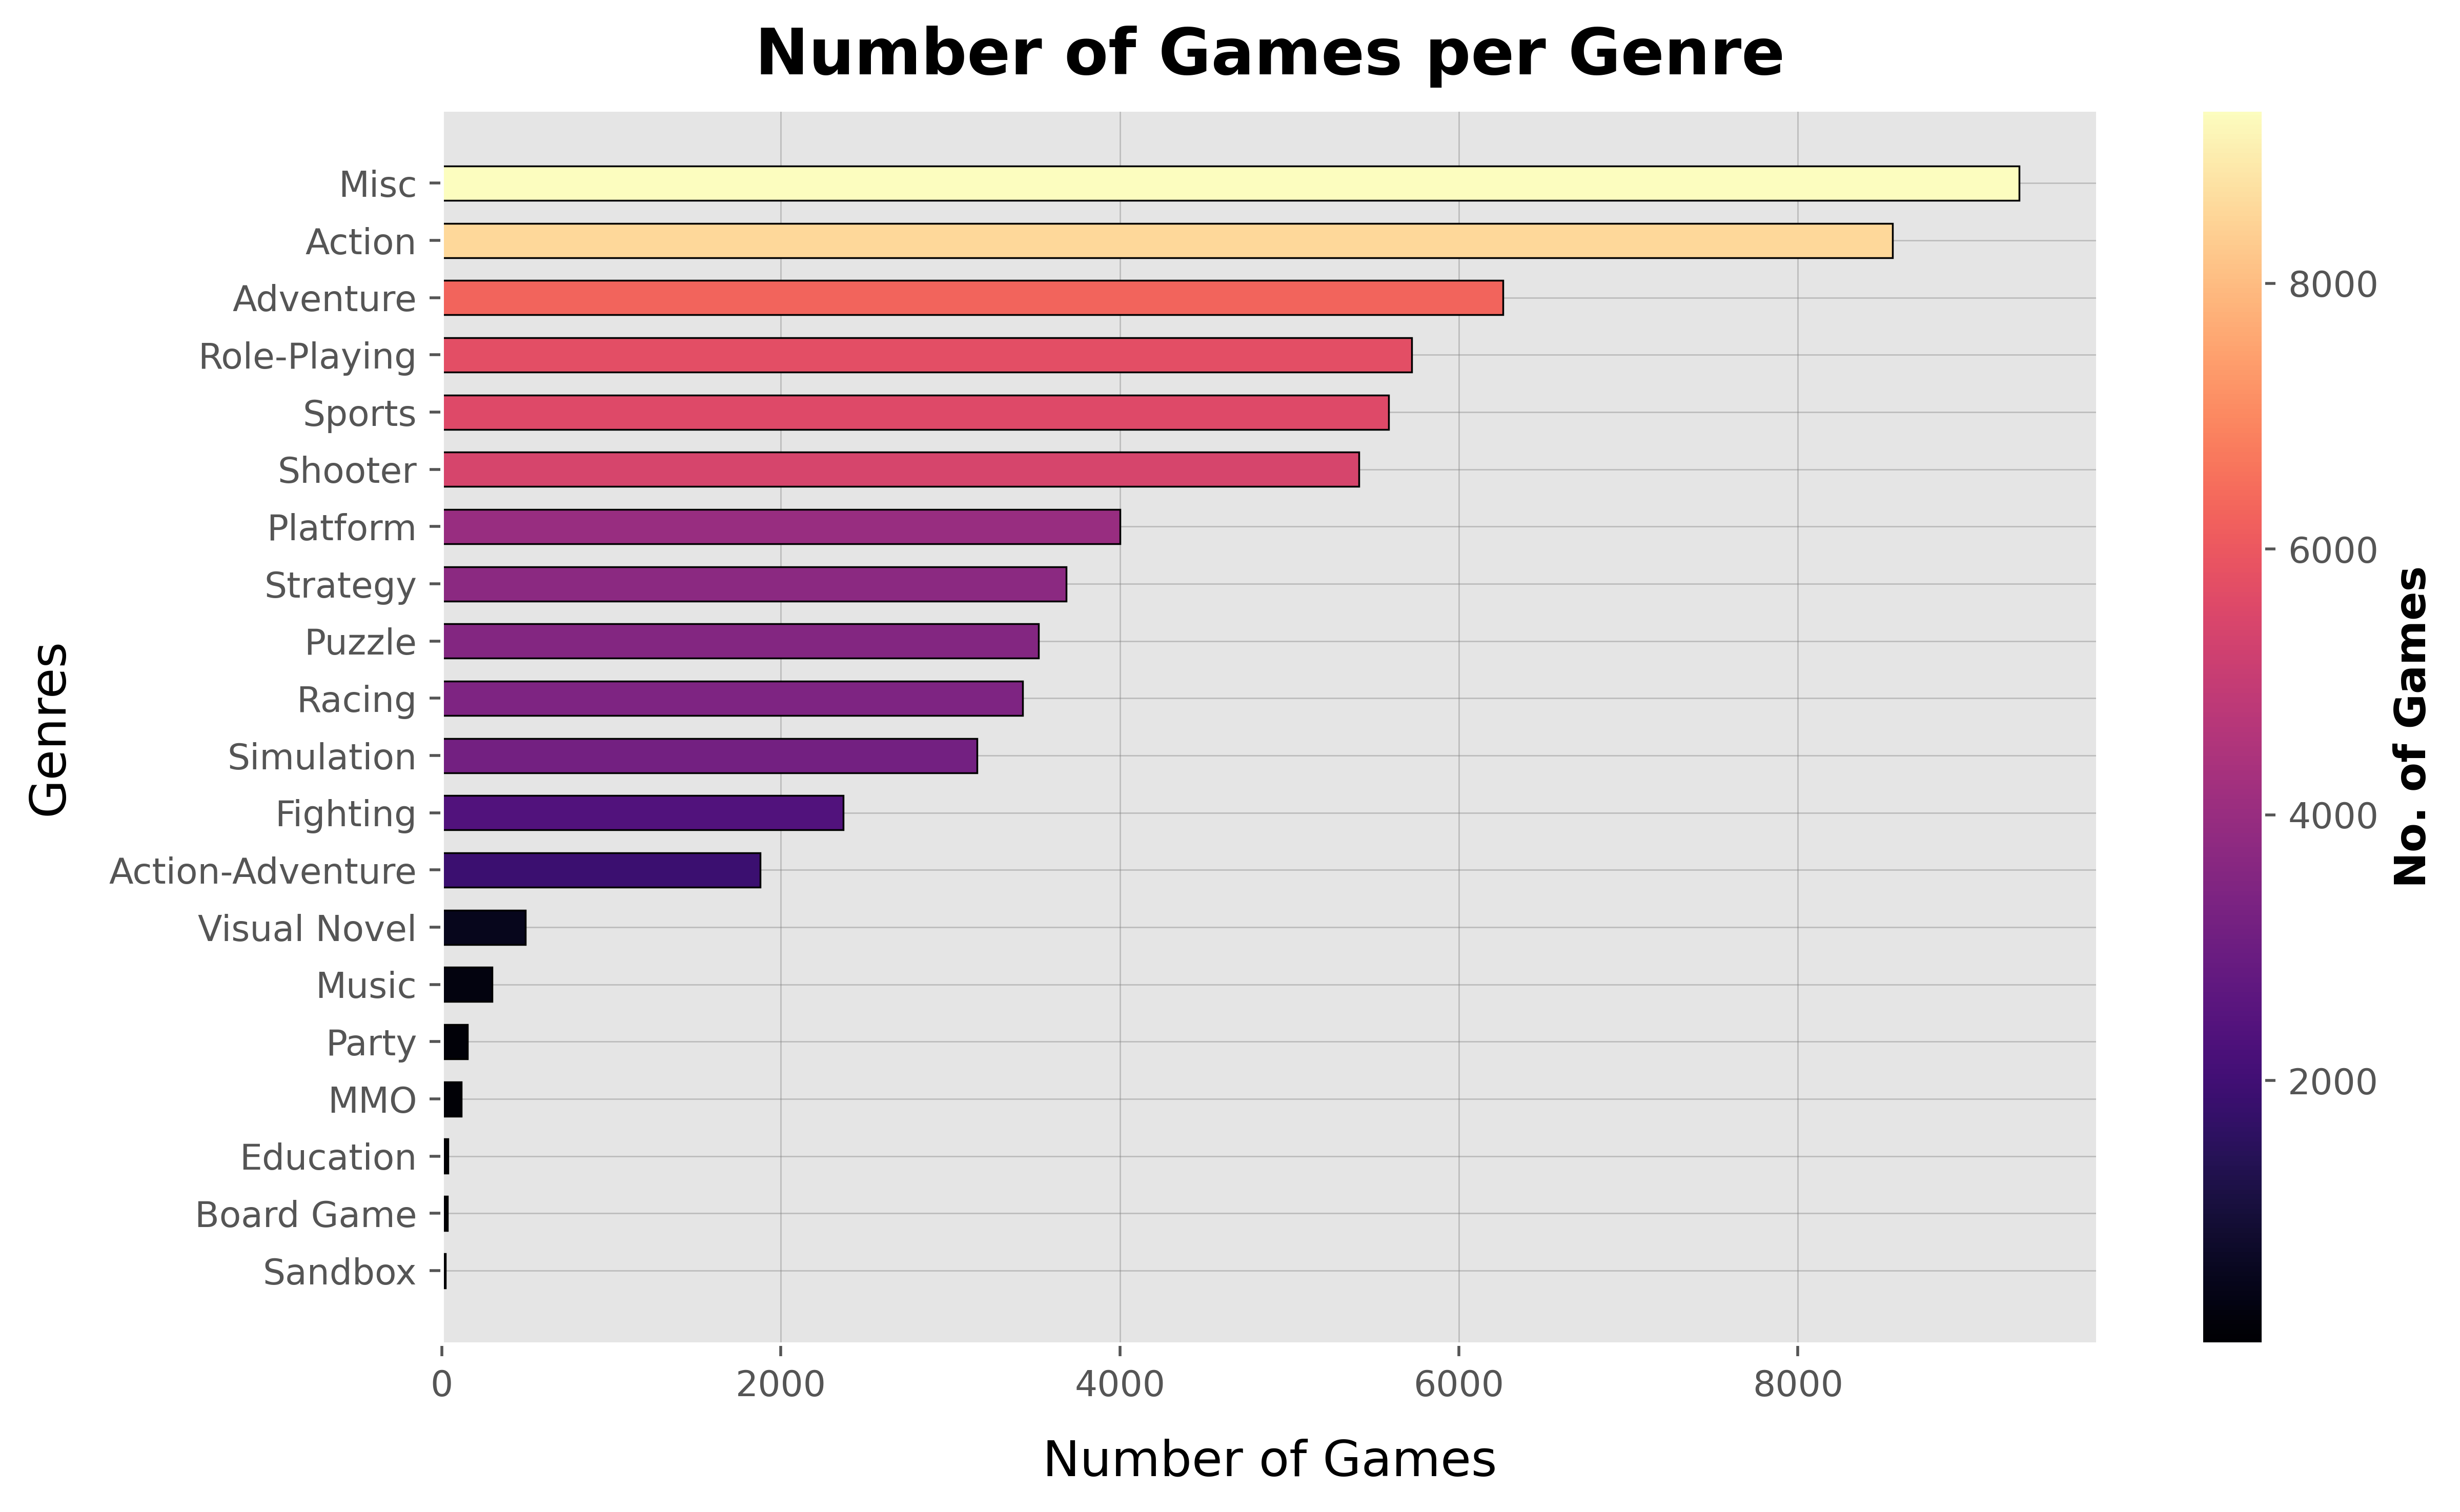

In [117]:
# Normalizing the data for colormap (0 to 1)
norm = mcolors.Normalize(
    vmin=games_per_genre['title'].min(),
    vmax=games_per_genre['title'].max()
)
cmap = plt.cm.magma
colors = cmap(norm(games_per_genre['title']))

fig, ax = plt.subplots(
    figsize=(10, 6),
    dpi=500,
)

ax.barh(
    y=games_per_genre.index,
    width=games_per_genre['title'],
    height=0.6,
    color=colors,
    edgecolor='black'
)

ax.set_title(
    label='Number of Games per Genre',
    fontsize=18,
    fontweight='bold',
    color='black',
    loc='center',
    pad=10
)

ax.set_xlabel(
    xlabel='Number of Games',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.set_ylabel(
    ylabel='Genres',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.grid(
    visible=True,
    which='major',
    axis='both',
    color='gray',
    linestyle='-',
    linewidth=0.4,
    alpha=0.4
)

# Adding colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(
    label='No. of Games',
    fontsize=12,
    fontweight='bold',
    color='black'
)

plt.tight_layout()
plt.show()

### Total Sales per Console

In [118]:
# Showing the total sales (`total_sales`) for each console (`console`).
# I will plot Pie Chart to demonstrate the share of varios consoles.
sales_per_console = df.groupby('console') \
                      .agg({'total_sales': 'sum'}) \
                      .sort_values(by='total_sales', ascending=False)

In [119]:
# I do not count anything that has less than one million sales.
sales_per_console = sales_per_console[sales_per_console['total_sales'] > 1]


# Extracting first 10 consoles.
sales_per_console = sales_per_console.iloc[:10]

In [120]:
console_names = sales_per_console.index.to_list()
total_sales = sales_per_console['total_sales'].to_list()

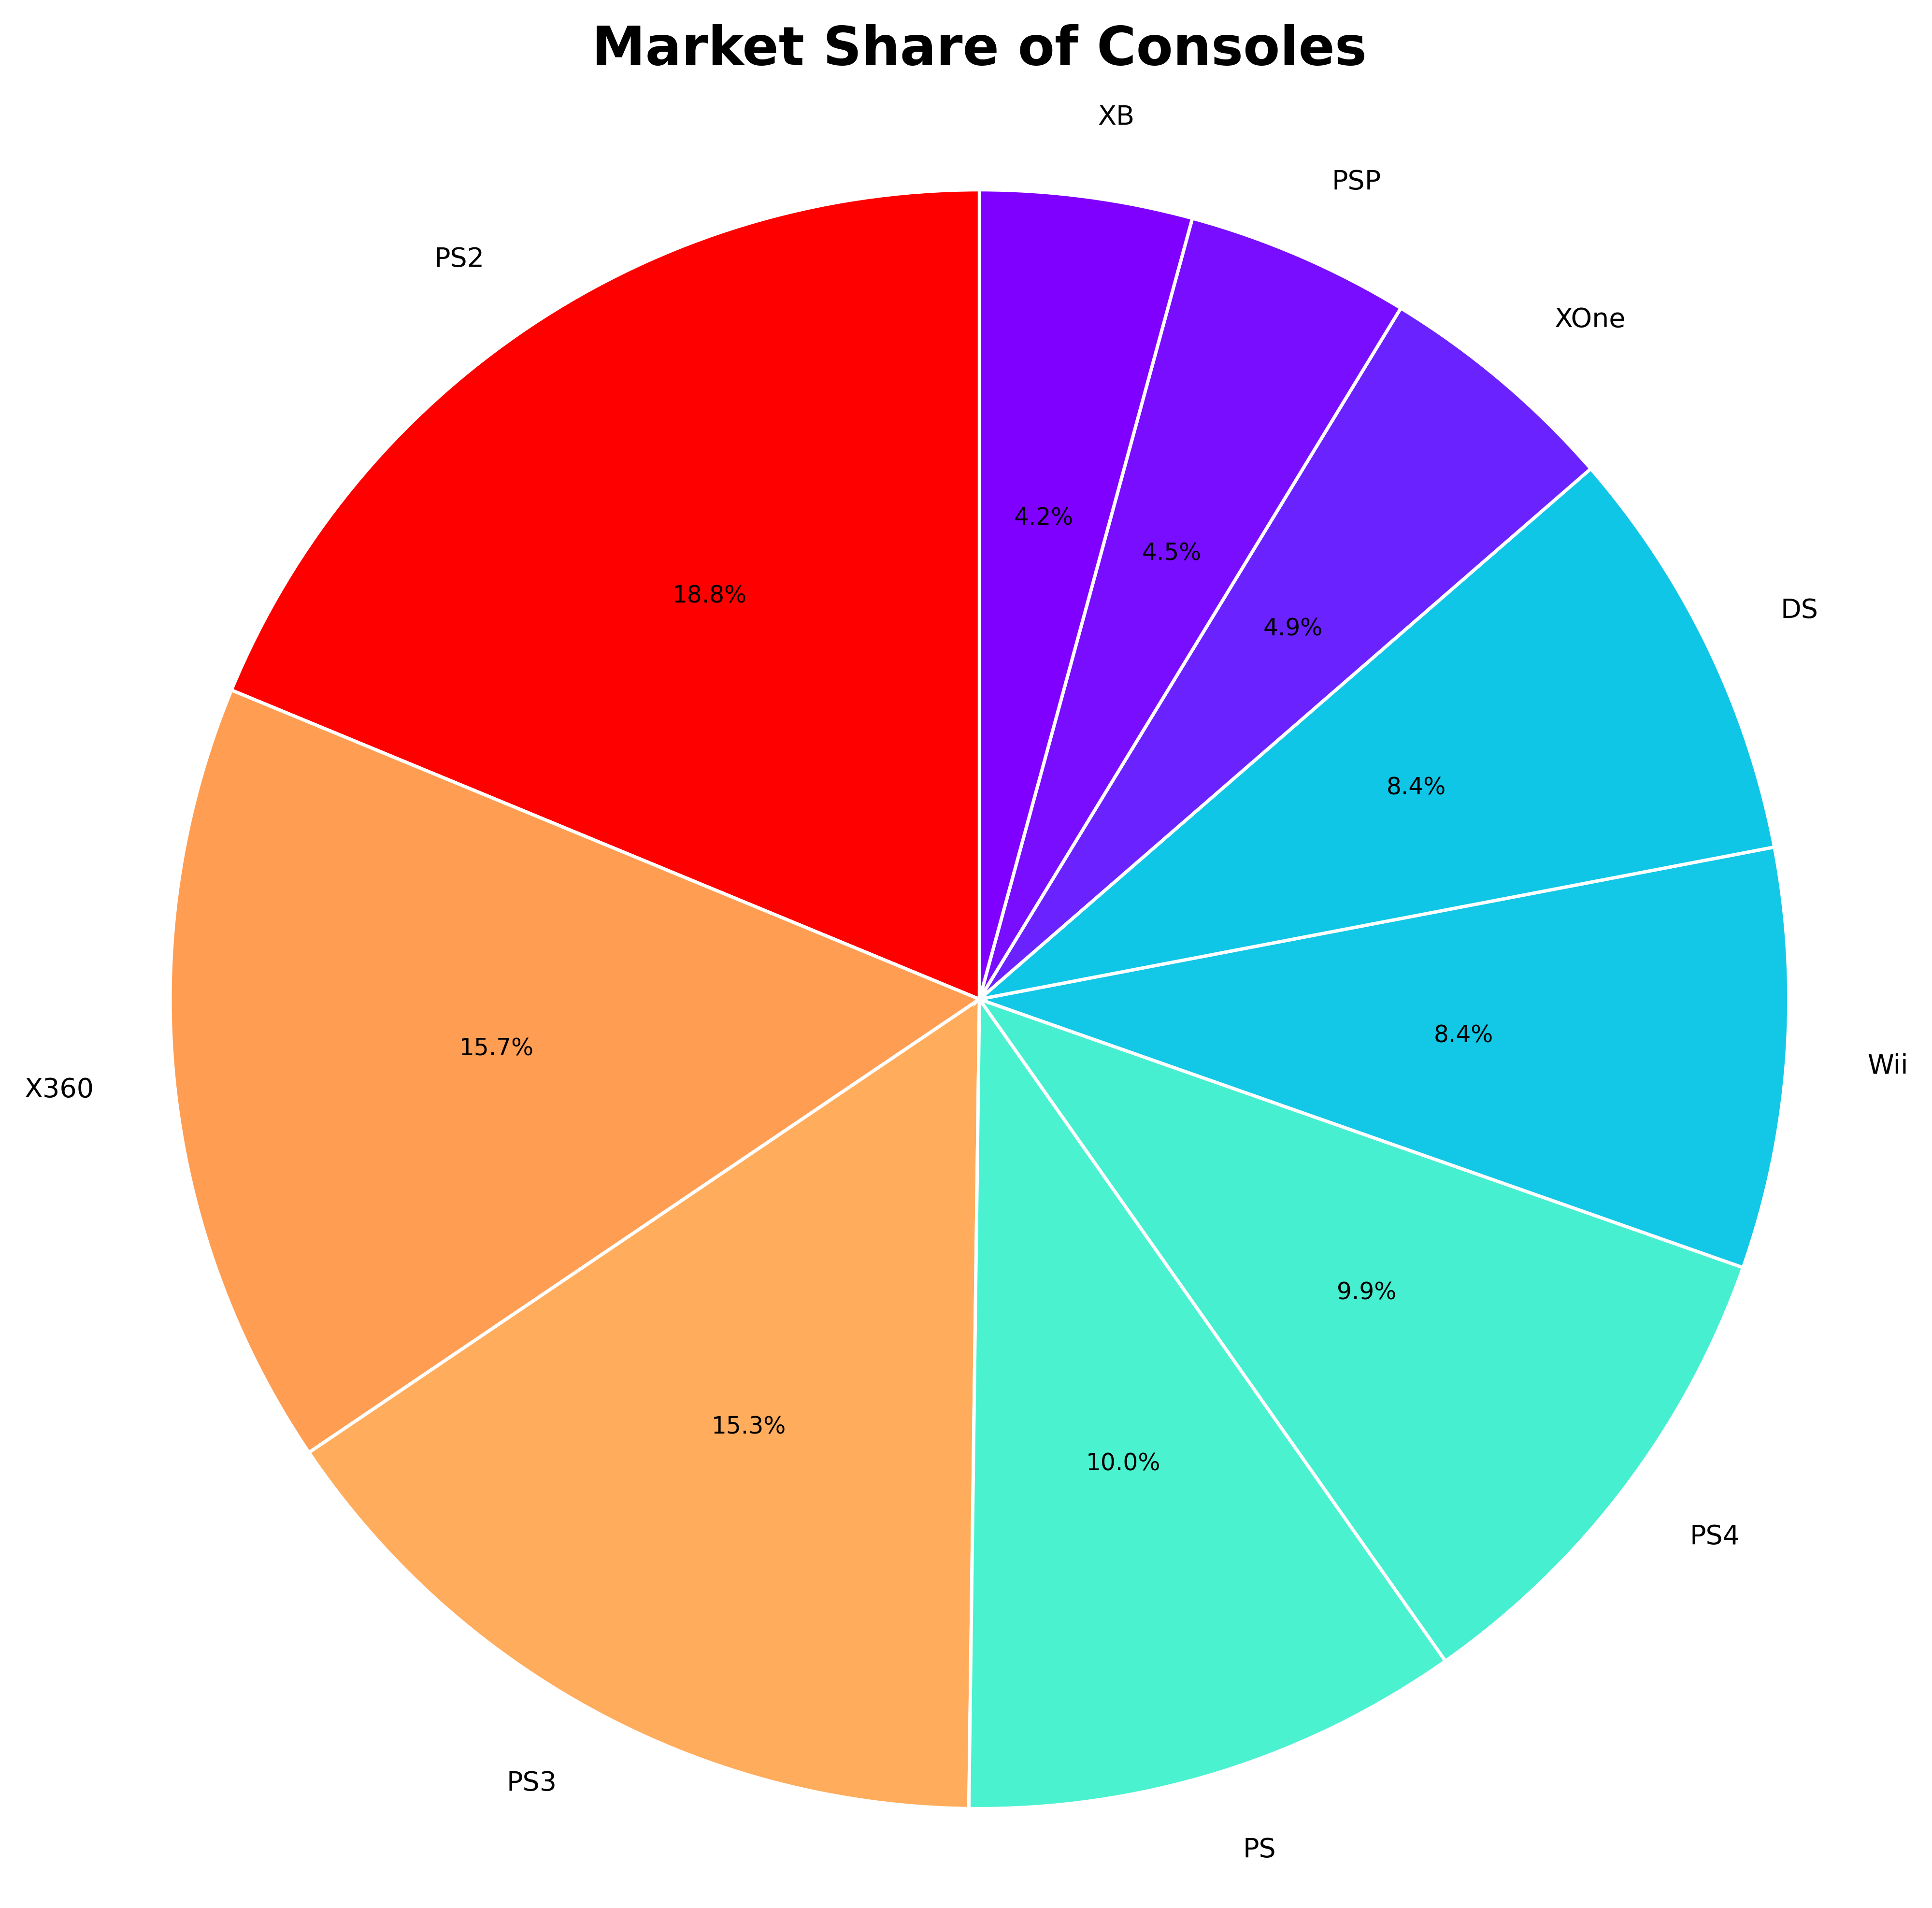

In [121]:
# Normalize total_sales data for colormap
norm = mcolors.Normalize(
    vmin=np.min(sales_per_console['total_sales']),
    vmax=np.max(sales_per_console['total_sales'])
)
cmap = plt.cm.rainbow
colors = cmap(norm(sales_per_console['total_sales']))

fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(8, 8),
    dpi=500,
    facecolor='white',
)

wedges, texts, autotexts = ax.pie(
    x=sales_per_console['total_sales'],
    labels=sales_per_console.index,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    radius=1,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    textprops={'fontsize': 8, 'color': 'black'},
)

for autotext in autotexts:
    autotext.set_fontsize(7)
    autotext.set_color('black')

ax.set_title(
    "Market Share of Consoles",
    fontsize=16,
    fontweight='bold',
    color='black',
    loc='center',
    pad=15
)

ax.axis('equal')

fig.tight_layout()
plt.show()


### Sales in North America for each Genre

In [122]:
# Calculating the average sales in North America (na_sales) for each `genre`
sales_per_genre_na = df.groupby('genre') \
                       .agg({'total_sales': 'sum'}) \
                       .sort_values(by='total_sales', ascending=True)

In [123]:
genres = sales_per_genre_na.index.to_list()
total_sales = sales_per_genre_na['total_sales'].to_list()

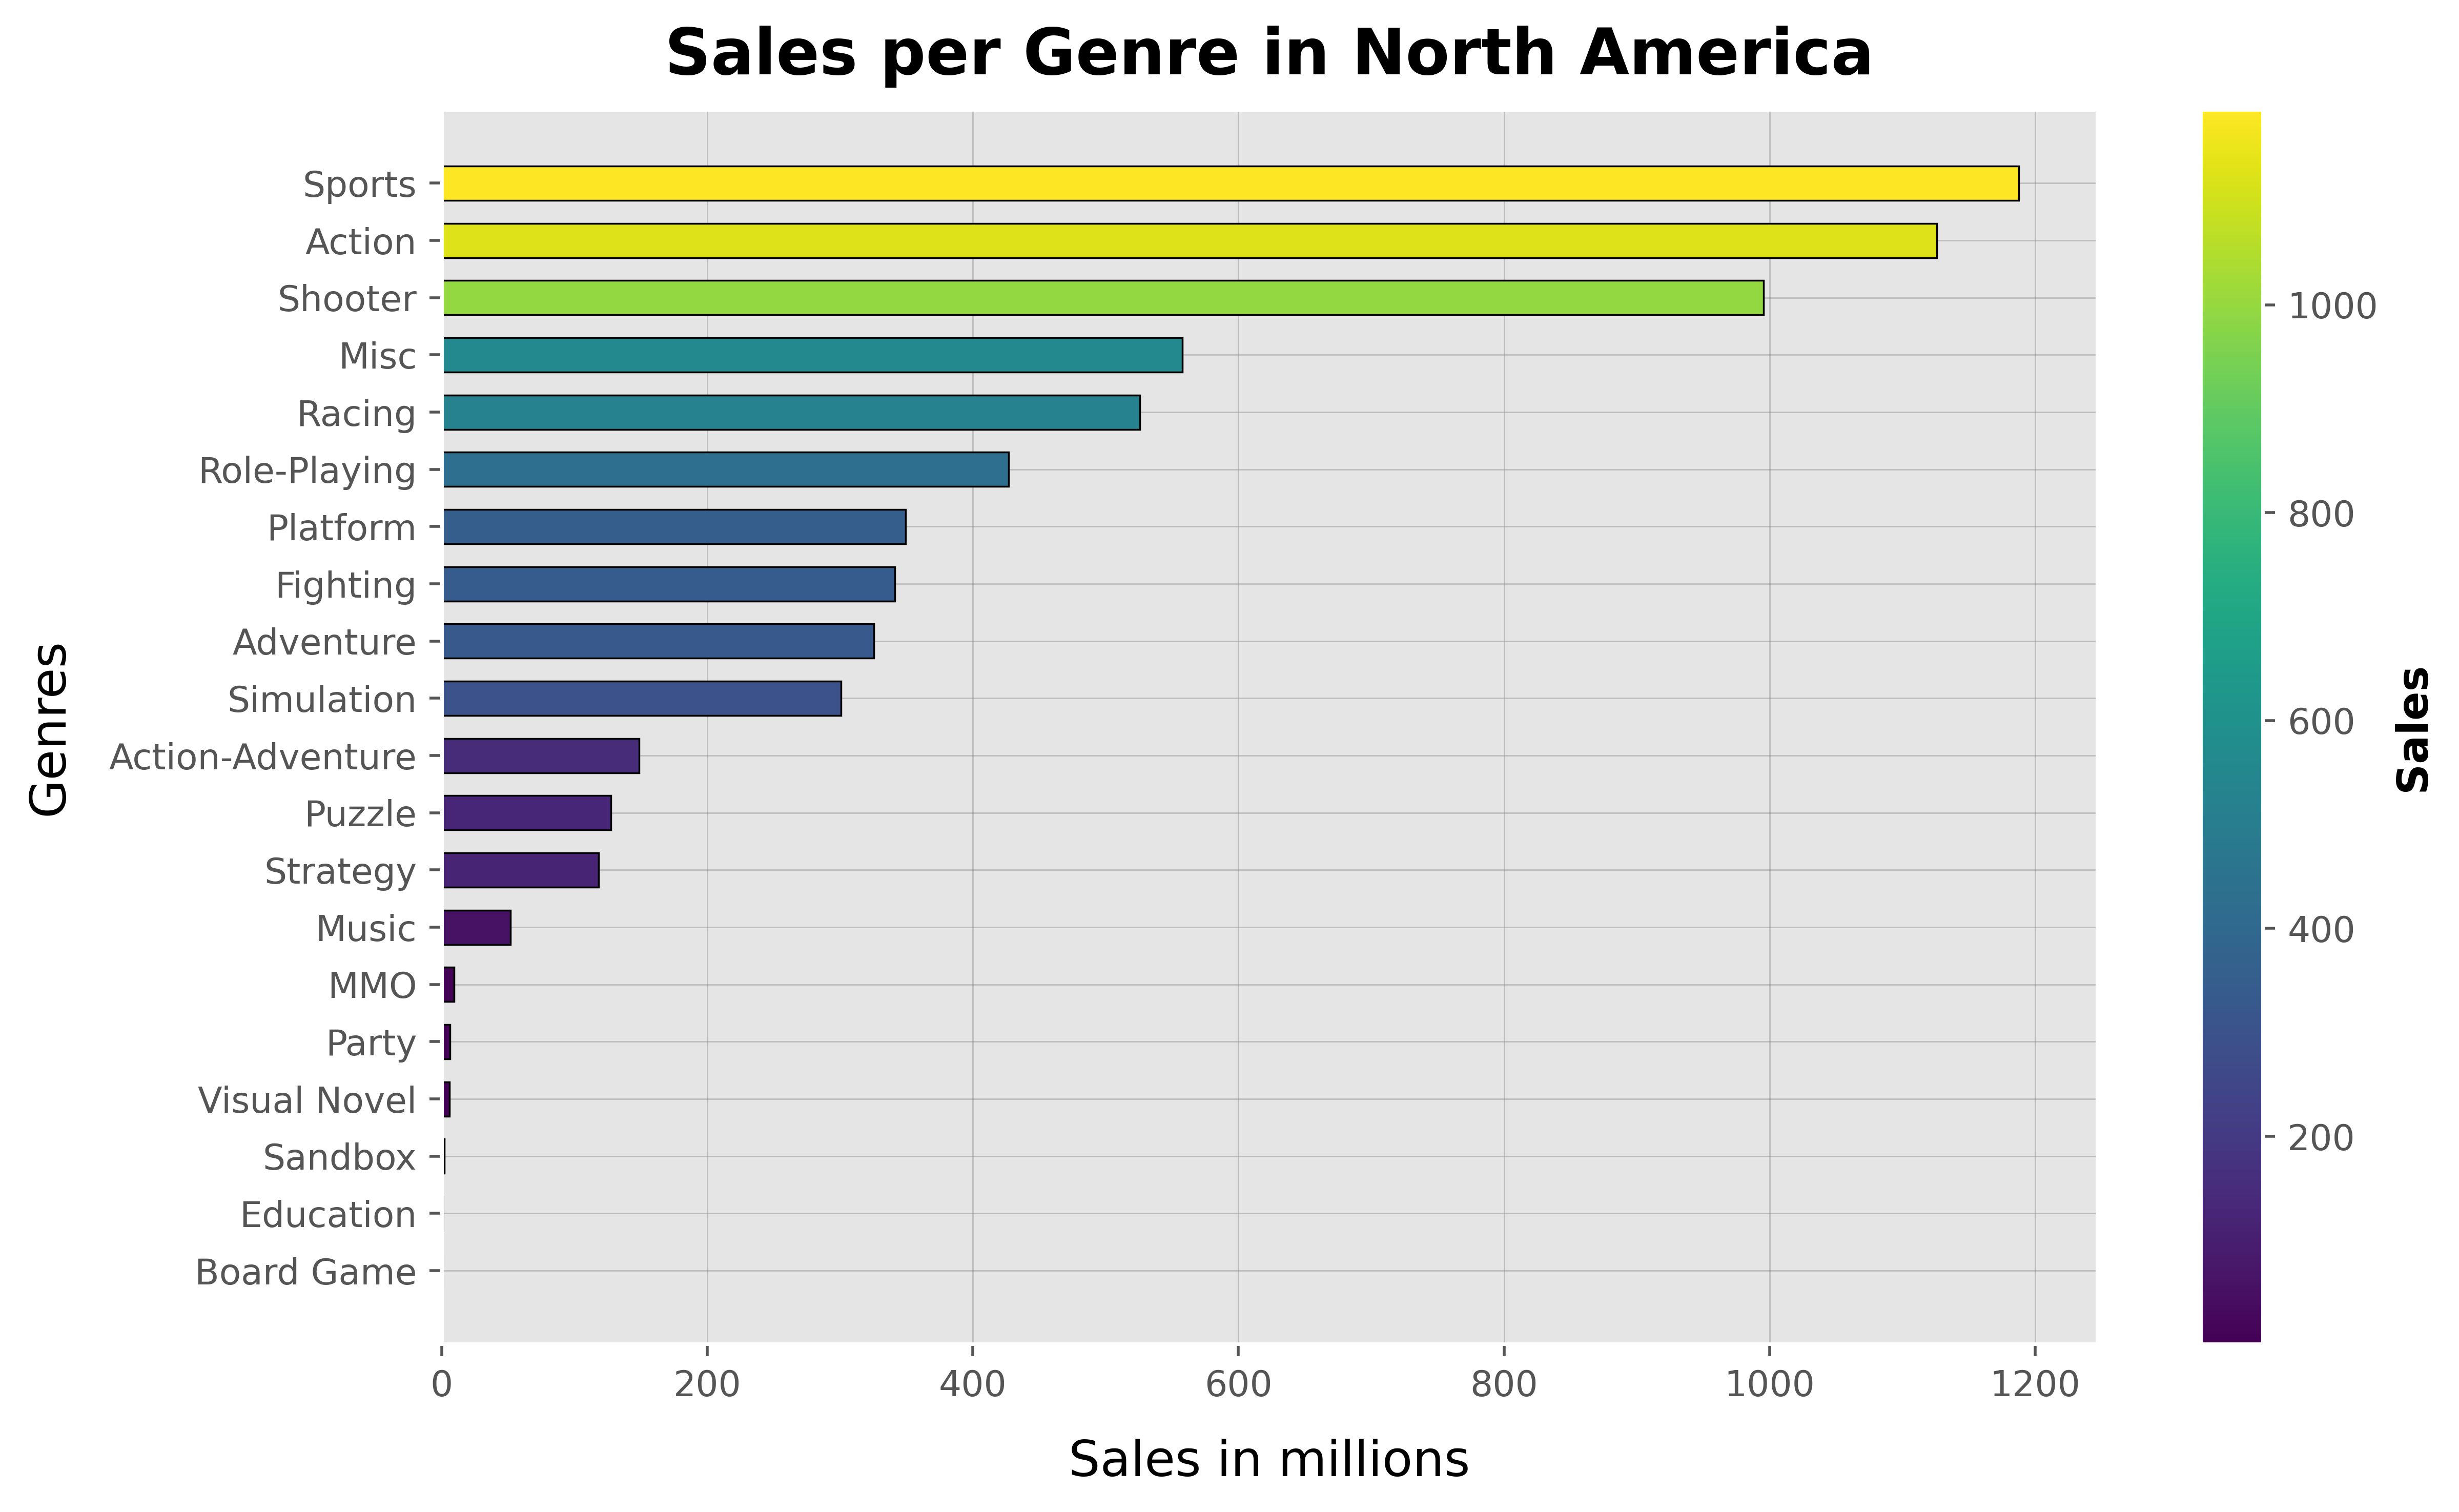

In [124]:
# Normalizing the data for colormap (0 to 1)
norm = mcolors.Normalize(
    vmin=sales_per_genre_na['total_sales'].min(),
    vmax=sales_per_genre_na['total_sales'].max()
)
cmap = plt.cm.viridis
colors = cmap(norm(sales_per_genre_na['total_sales']))

fig, ax = plt.subplots(
    figsize=(10, 6),
    dpi=500,
)

ax.barh(
    y=sales_per_genre_na.index,
    width=sales_per_genre_na['total_sales'],
    height=0.6,
    color=colors,
    edgecolor='black'
)

ax.set_title(
    label='Sales per Genre in North America',
    fontsize=18,
    fontweight='bold',
    color='black',
    loc='center',
    pad=10
)

ax.set_xlabel(
    xlabel='Sales in millions',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.set_ylabel(
    ylabel='Genres',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.grid(
    visible=True,
    which='major',
    axis='both',
    color='gray',
    linestyle='-',
    linewidth=0.4,
    alpha=0.4
)

# Adding colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(
    label='Sales',
    fontsize=12,
    fontweight='bold',
    color='black'
)

plt.tight_layout()
plt.show()

### Top Publishers

In [125]:

top_publishers = df.dropna(subset='publisher') \
                   .groupby('publisher') \
                   .agg(unique_titles=('title', 'nunique')) \
                   .sort_values(by='unique_titles', ascending=False) \
                   .drop(labels='Unknown')

In [126]:
# Omit publishers which have less tha 10 titles
top_publishers = top_publishers[top_publishers['unique_titles'] > 10]

# I will choose only first 20 publishers. 
top_publishers = top_publishers.iloc[: 20]


In [127]:
# Sorting for better visual of Bar Chart
top_publishers = top_publishers.sort_values(
    by='unique_titles', 
    ascending=True
)

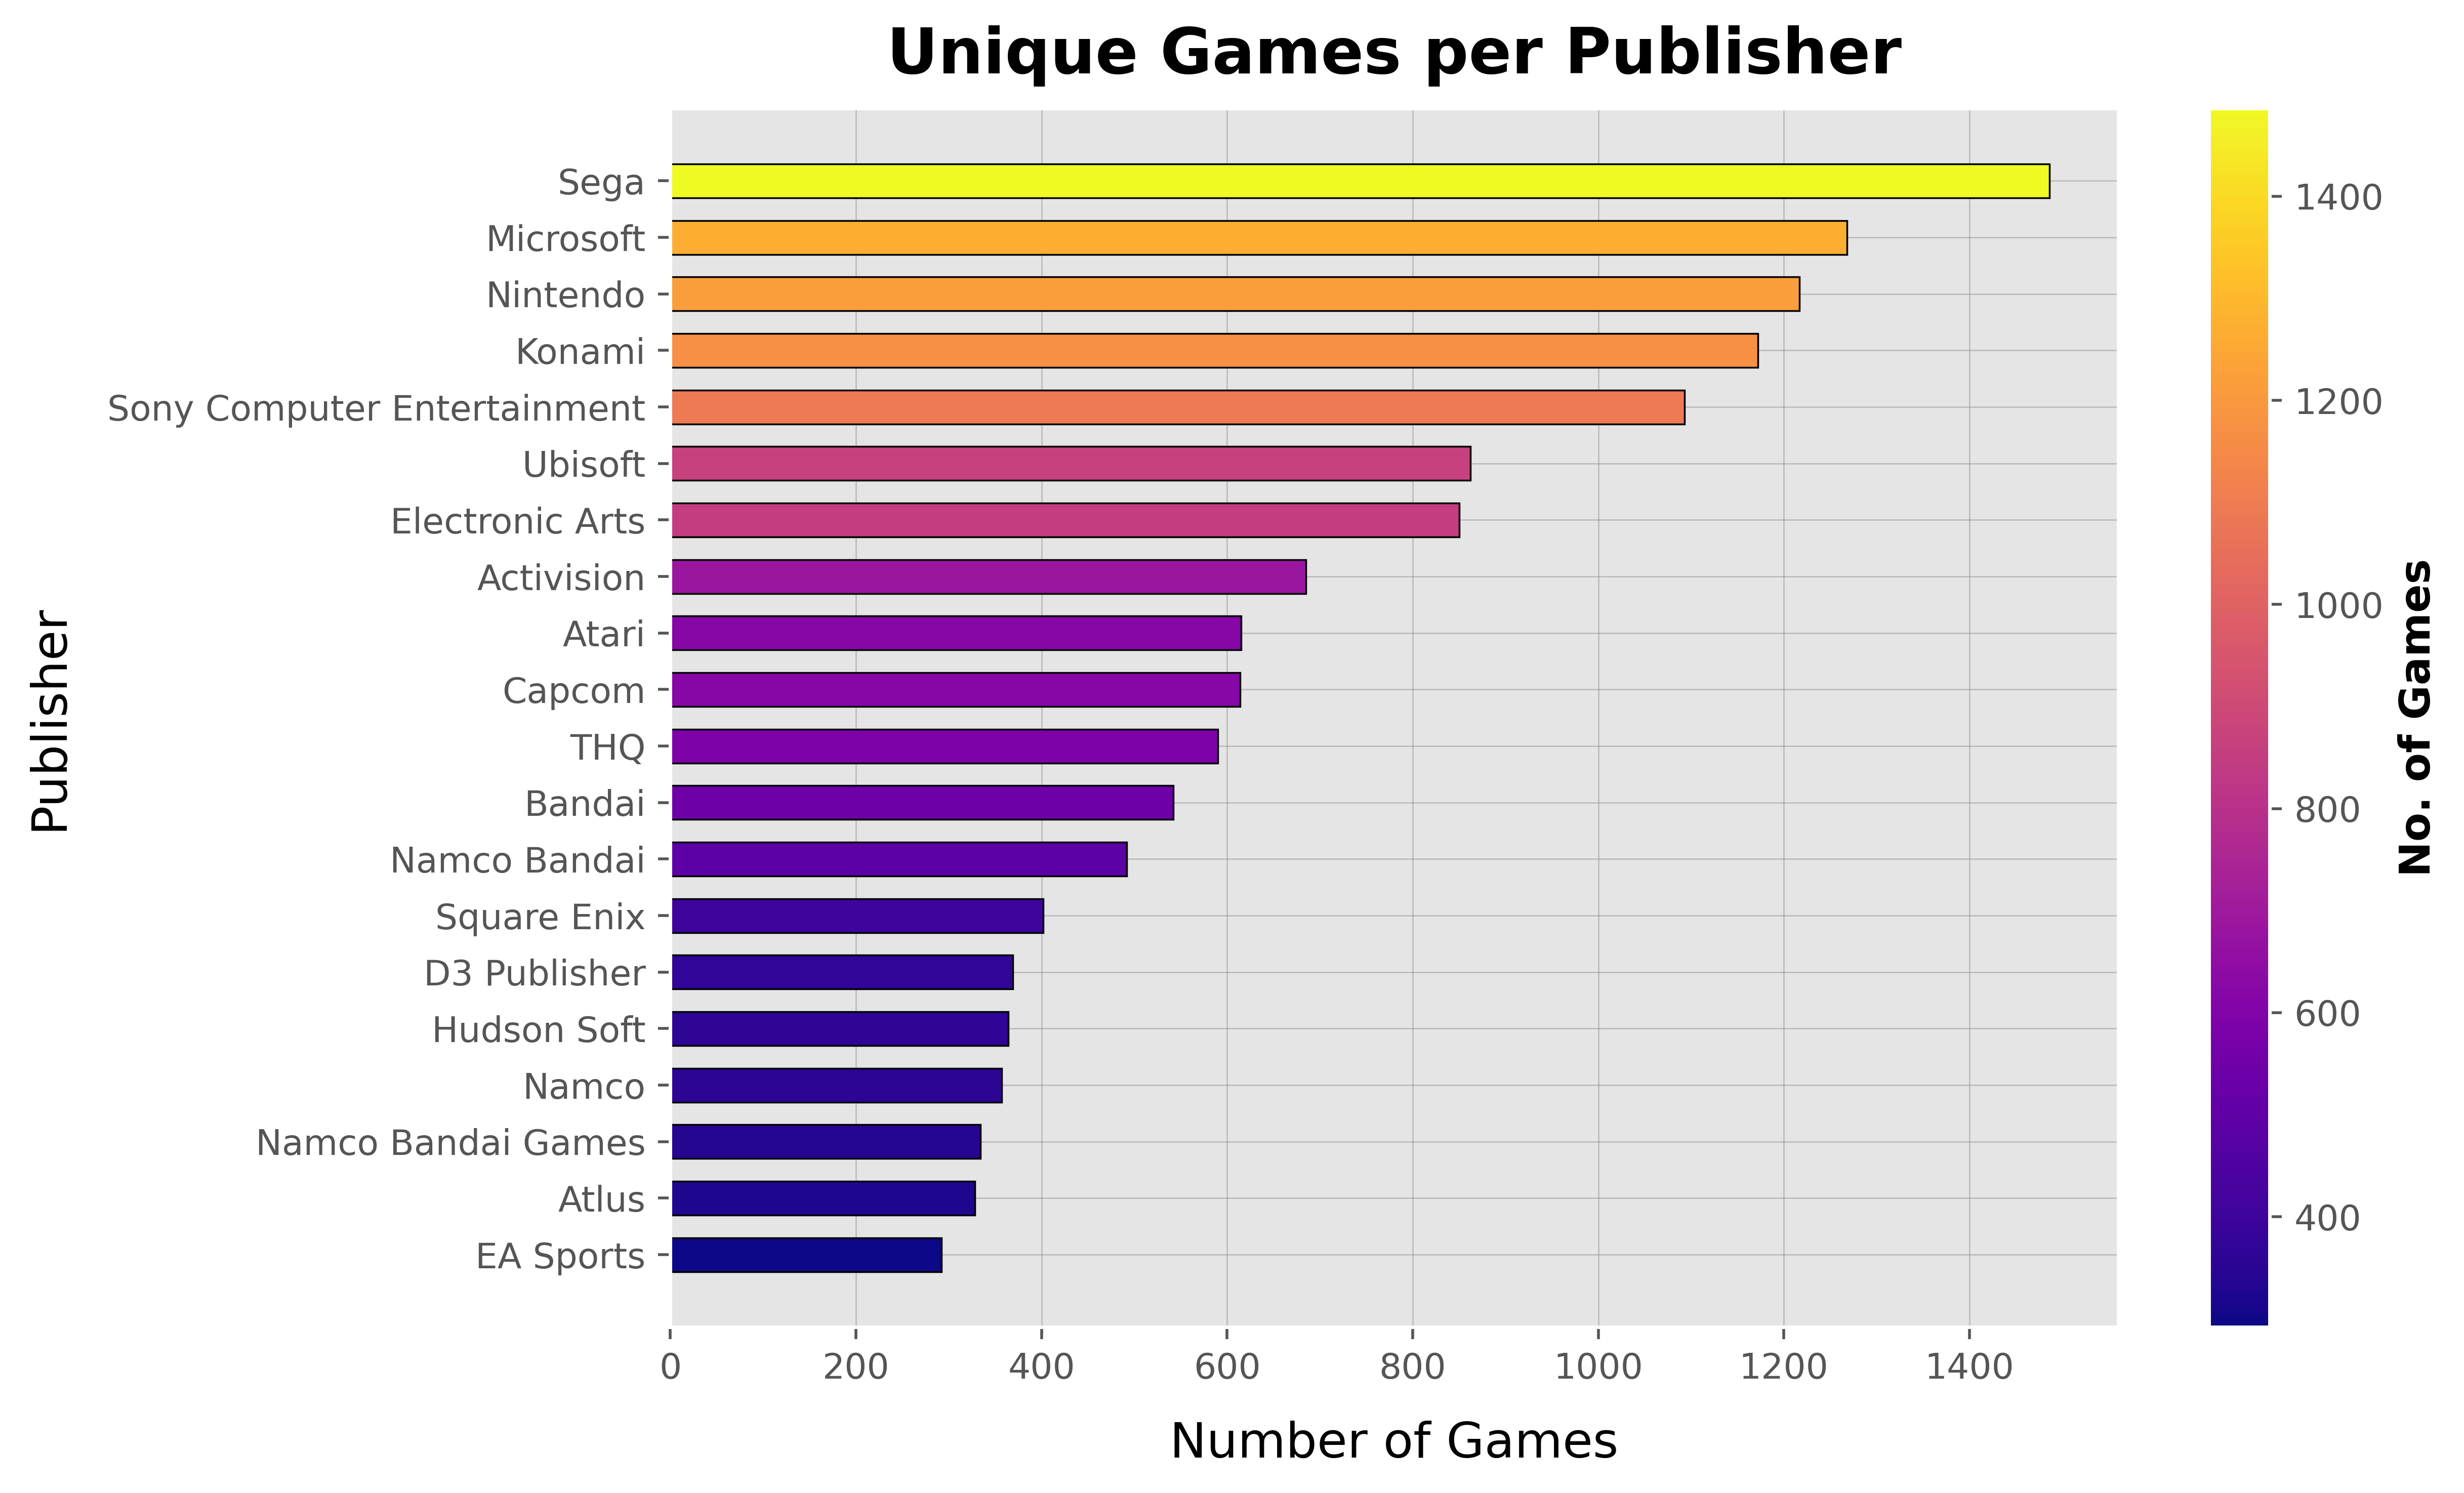

In [128]:
# Normalizing the data for colormap (0 to 1)
norm = mcolors.Normalize(
    vmin=top_publishers['unique_titles'].min(),
    vmax=top_publishers['unique_titles'].max()
)
cmap = plt.cm.plasma
colors = cmap(norm(top_publishers['unique_titles']))

fig, ax = plt.subplots(
    figsize=(10, 6),
    dpi=500,
)

ax.barh(
    y=top_publishers.index,
    width=top_publishers['unique_titles'],
    height=0.6,
    color=colors,
    edgecolor='black'
)

ax.set_title(
    label='Unique Games per Publisher',
    fontsize=18,
    fontweight='bold',
    color='black',
    loc='center',
    pad=10
)

ax.set_xlabel(
    xlabel='Number of Games',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.set_ylabel(
    ylabel='Publisher',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.grid(
    visible=True,
    which='major',
    axis='both',
    color='gray',
    linestyle='-',
    linewidth=0.4,
    alpha=0.4
)

# Adding colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(
    label='No. of Games',
    fontsize=12,
    fontweight='bold',
    color='black'
)

plt.tight_layout()
plt.show()

### Ranking Consoles

In [129]:
# Ranking the consoles (console) based on their total worldwide sales (total_sales).
# Will show the console name and its rank (1st, 2nd, 3rd, etc.)

console_rating = df.groupby('console').agg({'total_sales': 'sum'})
console_rating['rank'] = console_rating['total_sales'].rank(
    method='dense',
    ascending=False
)
console_rating = console_rating.sort_values(by='rank', ascending=True)
console_rating.head()

total_sales  rank
console                   
PS2          1027.76     1
X360          859.79     2
PS3            839.7     3
PS            546.25     4
PS4           539.92     5

### The Perfect Storm

In [130]:
"""
The Perfect Storm
- The critic_score is greater than 9.0.
- The total_sales are greater than 5 million.
- No single region (na_sales, jp_sales, pal_sales, other_sales) 
    accounts for more than 60% of the total_sales.
"""

perfect_storm = df[
    (df['critic_score'] >= 9.0) 
    & 
    (df['total_sales'] >= 5)
    & 
    (df['jp_sales'] <= df['total_sales'] * 0.6)
    & 
    (df['na_sales'] <= df['total_sales'] * 0.6)
    & 
    (df['pal_sales'] <= df['total_sales'] * 0.6)
    & 
    (df['other_sales'] <= df['total_sales'] * 0.6)
]
perfect_storm.head()

title console             genre       publisher  \
0            Grand Theft Auto V     PS3            Action  Rockstar Games   
1            Grand Theft Auto V     PS4            Action  Rockstar Games   
2   Grand Theft Auto: Vice City     PS2            Action  Rockstar Games   
7         Red Dead Redemption 2     PS4  Action-Adventure  Rockstar Games   
13         Grand Theft Auto III     PS2            Action  Rockstar Games   

         developer  critic_score  total_sales  na_sales  jp_sales  pal_sales  \
0   Rockstar North           9.4        20.32      6.37      0.99       9.85   
1   Rockstar North           9.7        19.39      6.06       0.6       9.71   
2   Rockstar North           9.6        16.15      8.41      0.47       5.49   
7   Rockstar Games           9.8        13.94      5.26      0.21       6.21   
13      DMA Design           9.5         13.1      6.99       0.3       4.51   

    other_sales release_date  
0          3.12   2013-09-17  
1          3.02   2014-11-18  
2          1.78   2002-10-28  
7          2.26   2018-10-26  
13          1.3   2001-10-23

### Rivalry between Shooters and Action

In [131]:
# I am going to calculate the total worldwide sales (total_sales) 
# for the 'Action' genre and the 'Shooter' genre for each release year. 
# `release_year` I will define before doing this. 
# This will create a dataset to plot two lines over time, 
# showing the trend and rivalry between these two major genres.

df['release_year'] = df['release_date'].dt.year

In [132]:
rivalry = df[
    (df['genre'] == 'Action') 
    | 
    (df['genre'] == 'Shooter')].groupby(['release_year', 'genre']) \
                               .agg({'total_sales': 'sum'})

In [133]:
rivalry.head()

total_sales
release_year genre               
1977.0       Action          1.25
             Shooter         0.98
1978.0       Action          1.18
             Shooter          0.0
1979.0       Action          0.31

In [134]:
rivalry = rivalry.reset_index()
rivalry = rivalry.drop(labels=94, axis=0)

In [135]:
rivalry.head()

release_year    genre  total_sales
0        1977.0   Action         1.25
1        1977.0  Shooter         0.98
2        1978.0   Action         1.18
3        1978.0  Shooter          0.0
4        1979.0   Action         0.31

In [136]:
action_values = rivalry[rivalry['genre'] == 'Action']['total_sales']
shooter_values = rivalry[rivalry['genre'] == 'Shooter']['total_sales']
years = list(range(1977, 2024))

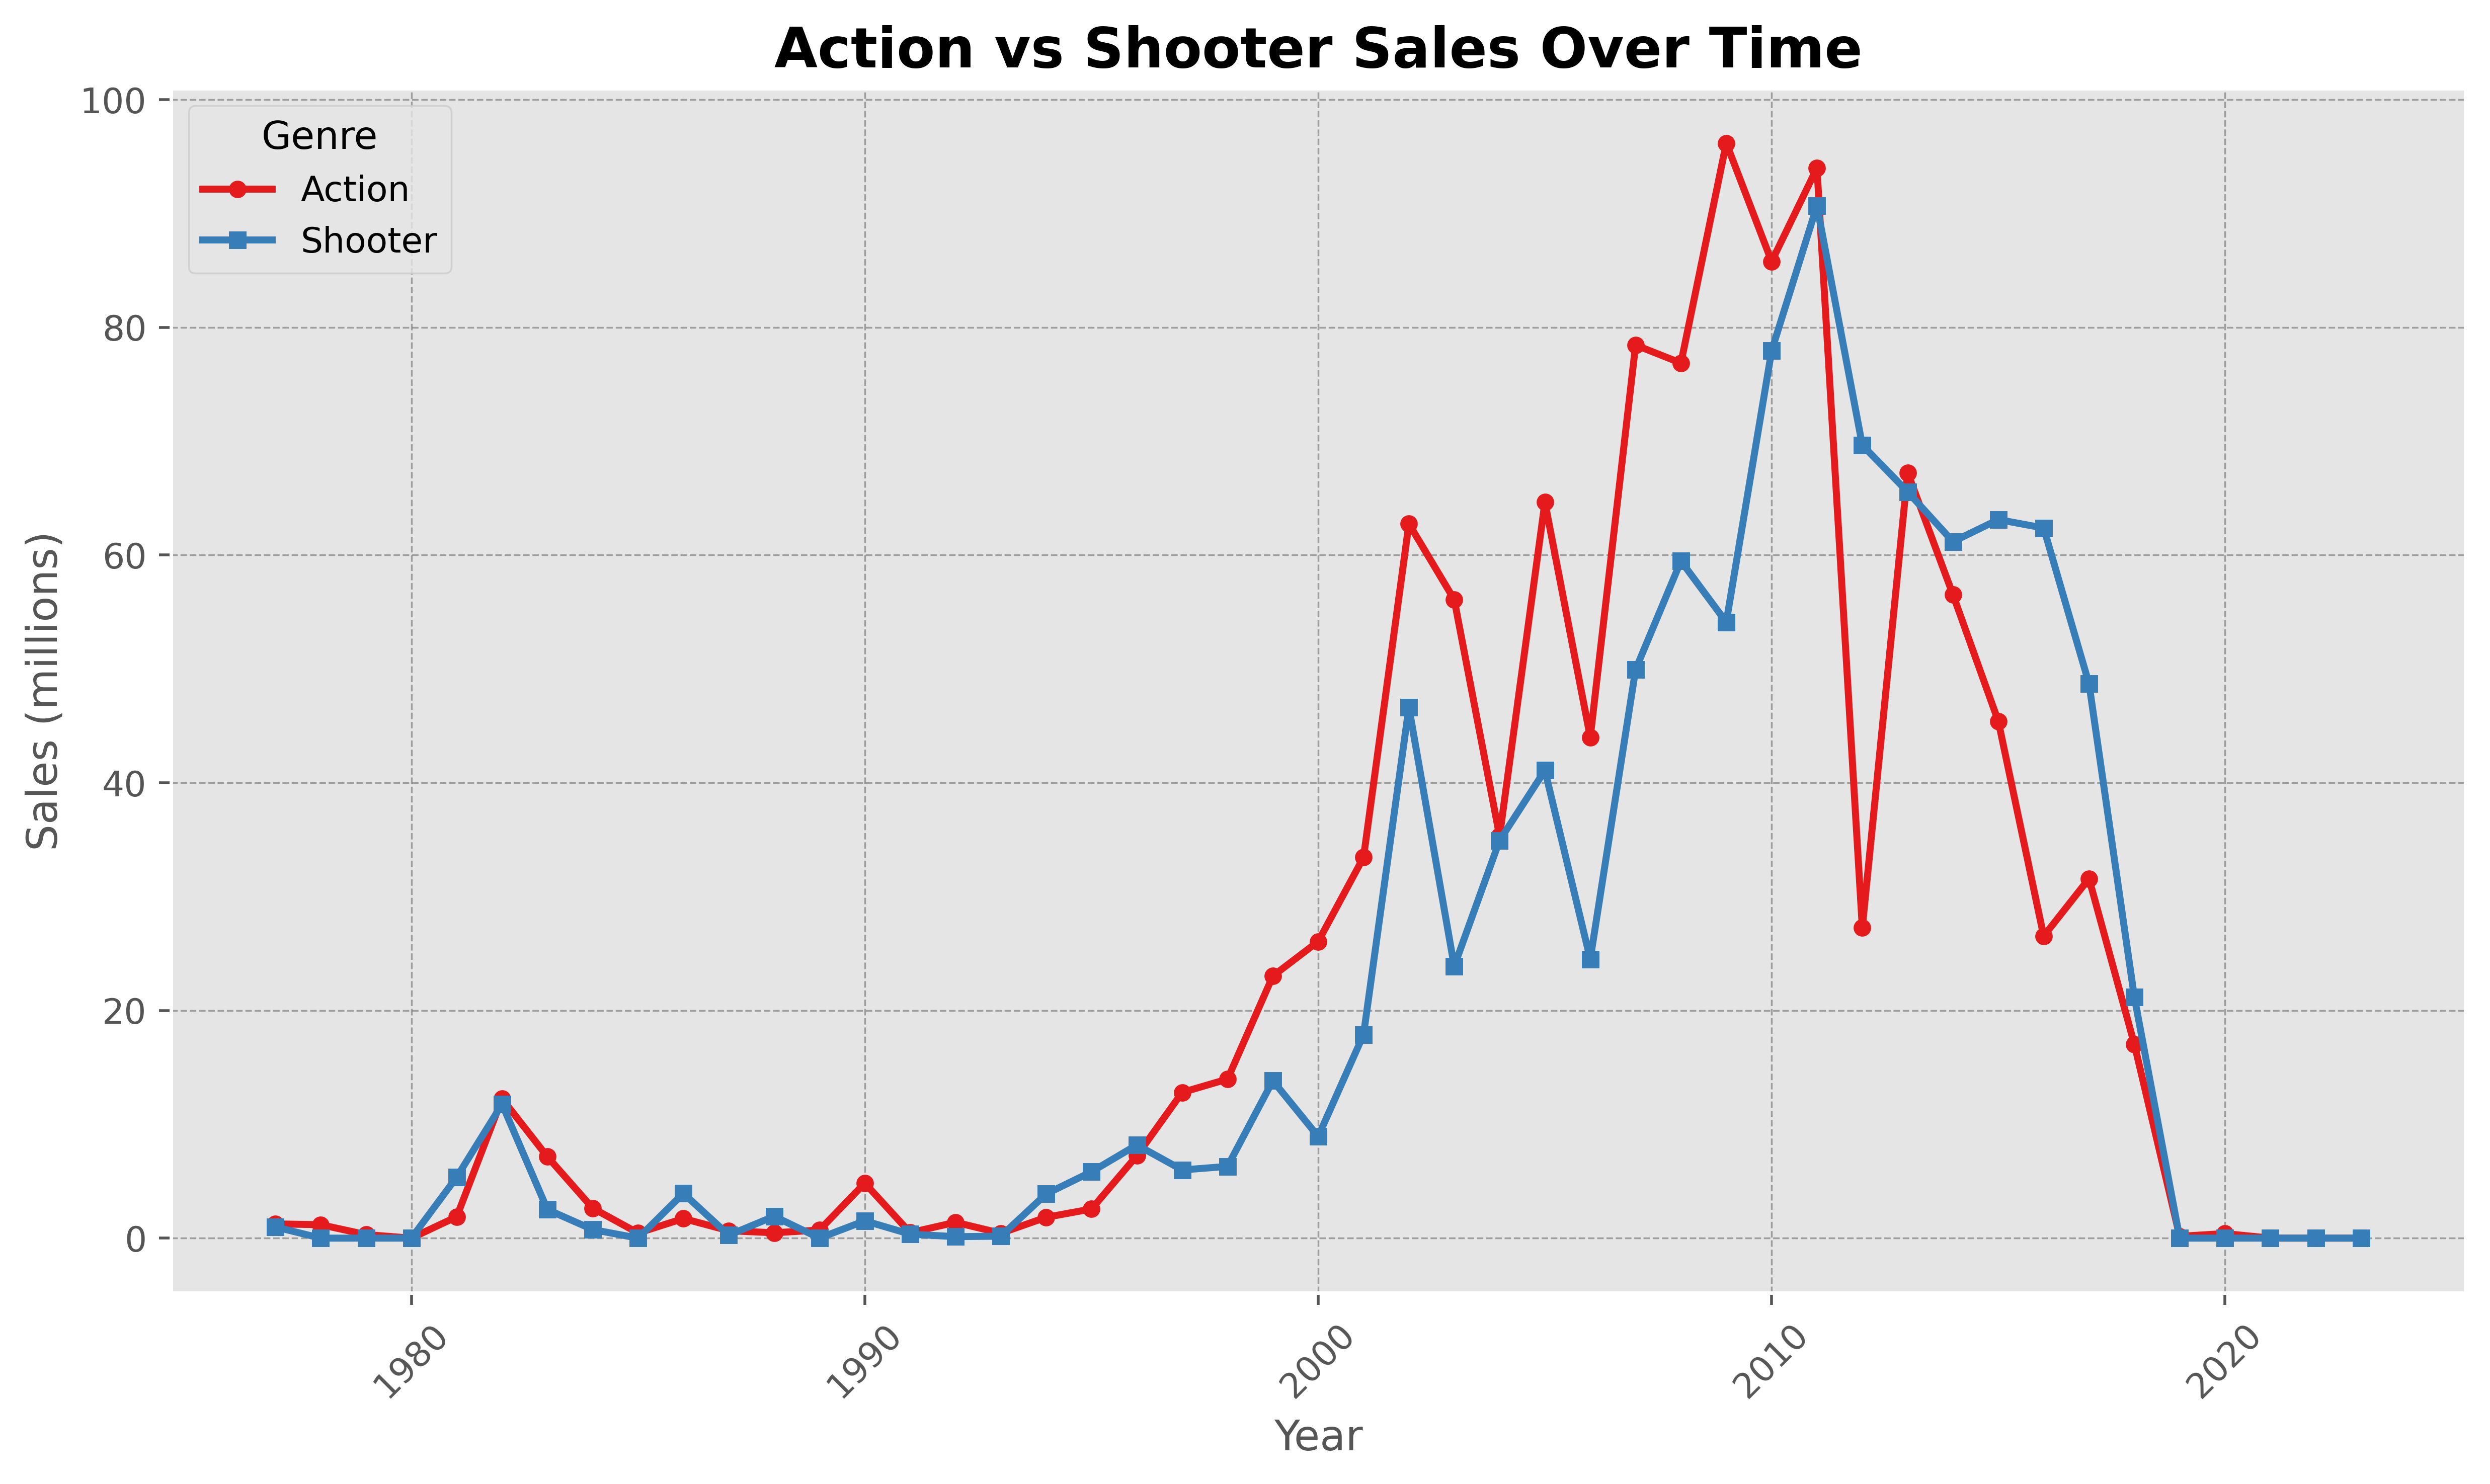

In [137]:
fig, ax = plt.subplots(dpi=500, figsize=(10, 6))

ax.plot(
    years,
    action_values,
    color='#e41a1c',         # Nice red
    linestyle='-',
    linewidth=2,
    marker='o',
    markersize=4,
    label='Action'
)

ax.plot(
    years,
    shooter_values,
    color='#377eb8',         # Nice blue
    linestyle='-',
    linewidth=2,
    marker='s',
    markersize=4,
    label='Shooter'
)

ax.set_title(
    label="Action vs Shooter Sales Over Time", 
    fontsize=16, 
    fontweight='bold')
ax.set_xlabel(
    xlabel="Year", 
    fontsize=12)
ax.set_ylabel(
    ylabel="Sales (millions)", 
    fontsize=12)

ax.tick_params(axis='both', labelsize=10)
plt.xticks(rotation=45)

ax.grid(
    visible=True, 
    color='gray',
    linestyle='--', 
    linewidth=0.5, 
    alpha=0.7)

# Legend
ax.legend(title="Genre", fontsize=10, title_fontsize=11, loc='upper left')

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

plt.tight_layout()
plt.show()

### Market Dominance by Console

For each console (`console`), I will calculate the sum of sales for each region (`na_sales`, `jp_sales`, `pal_sales`, `other_sales`). This, in turn, creates a perfect dataset for a stacked bar chart, showing which consoles were most popular in which parts of the world.

In [138]:
dict_for_agg = {
    'na_sales': 'sum',
    'jp_sales': 'sum',
    'pal_sales': 'sum',
    'other_sales': 'sum'
}

console_dominance = df.groupby('console').agg(dict_for_agg)

# Filter out consoles with at least 1 mln in any region
console_dominance = console_dominance[
    (console_dominance['na_sales'] > 1) &
    (console_dominance['jp_sales'] > 1) &
    (console_dominance['pal_sales'] > 1) &
    (console_dominance['other_sales'] > 1)
]

console_dominance

na_sales  jp_sales  pal_sales  other_sales
console                                            
3DS         30.37     41.74      22.24         4.88
DS         264.84      64.2      94.33        33.88
GBA        140.41     23.94      54.86         4.47
GC          86.31      6.09      23.77          2.9
N64         66.36      8.44      16.67          2.1
NS          17.71      4.26      11.63         2.75
PS         263.26     88.32     163.73         31.1
PS2        489.96     87.63     296.37       153.94
PS3         351.1     67.68     302.22       118.93
PS4        192.18     30.69      233.4        83.55
PSP         96.56     52.29      59.79        36.59
PSV         13.04     26.95      15.18         7.81
Wii        285.42     16.84     117.72        38.85
WiiU        16.44      3.84      12.39         2.73
X360        528.4     10.16      244.5        76.74

In [139]:
consoles = console_dominance.index.to_list()
na_sales = console_dominance['na_sales']
jp_sales = console_dominance['jp_sales']
pal_sales = console_dominance['pal_sales']
other_sales = console_dominance['other_sales']

/tmp/ipykernel_5167/3710684844.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  na = na_sales[i]
/tmp/ipykernel_5167/3710684844.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  jp = jp_sales[i]
/tmp/ipykernel_5167/3710684844.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pal = pal_sales[i]
/tmp/ipykernel_5167/3710684844.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versi

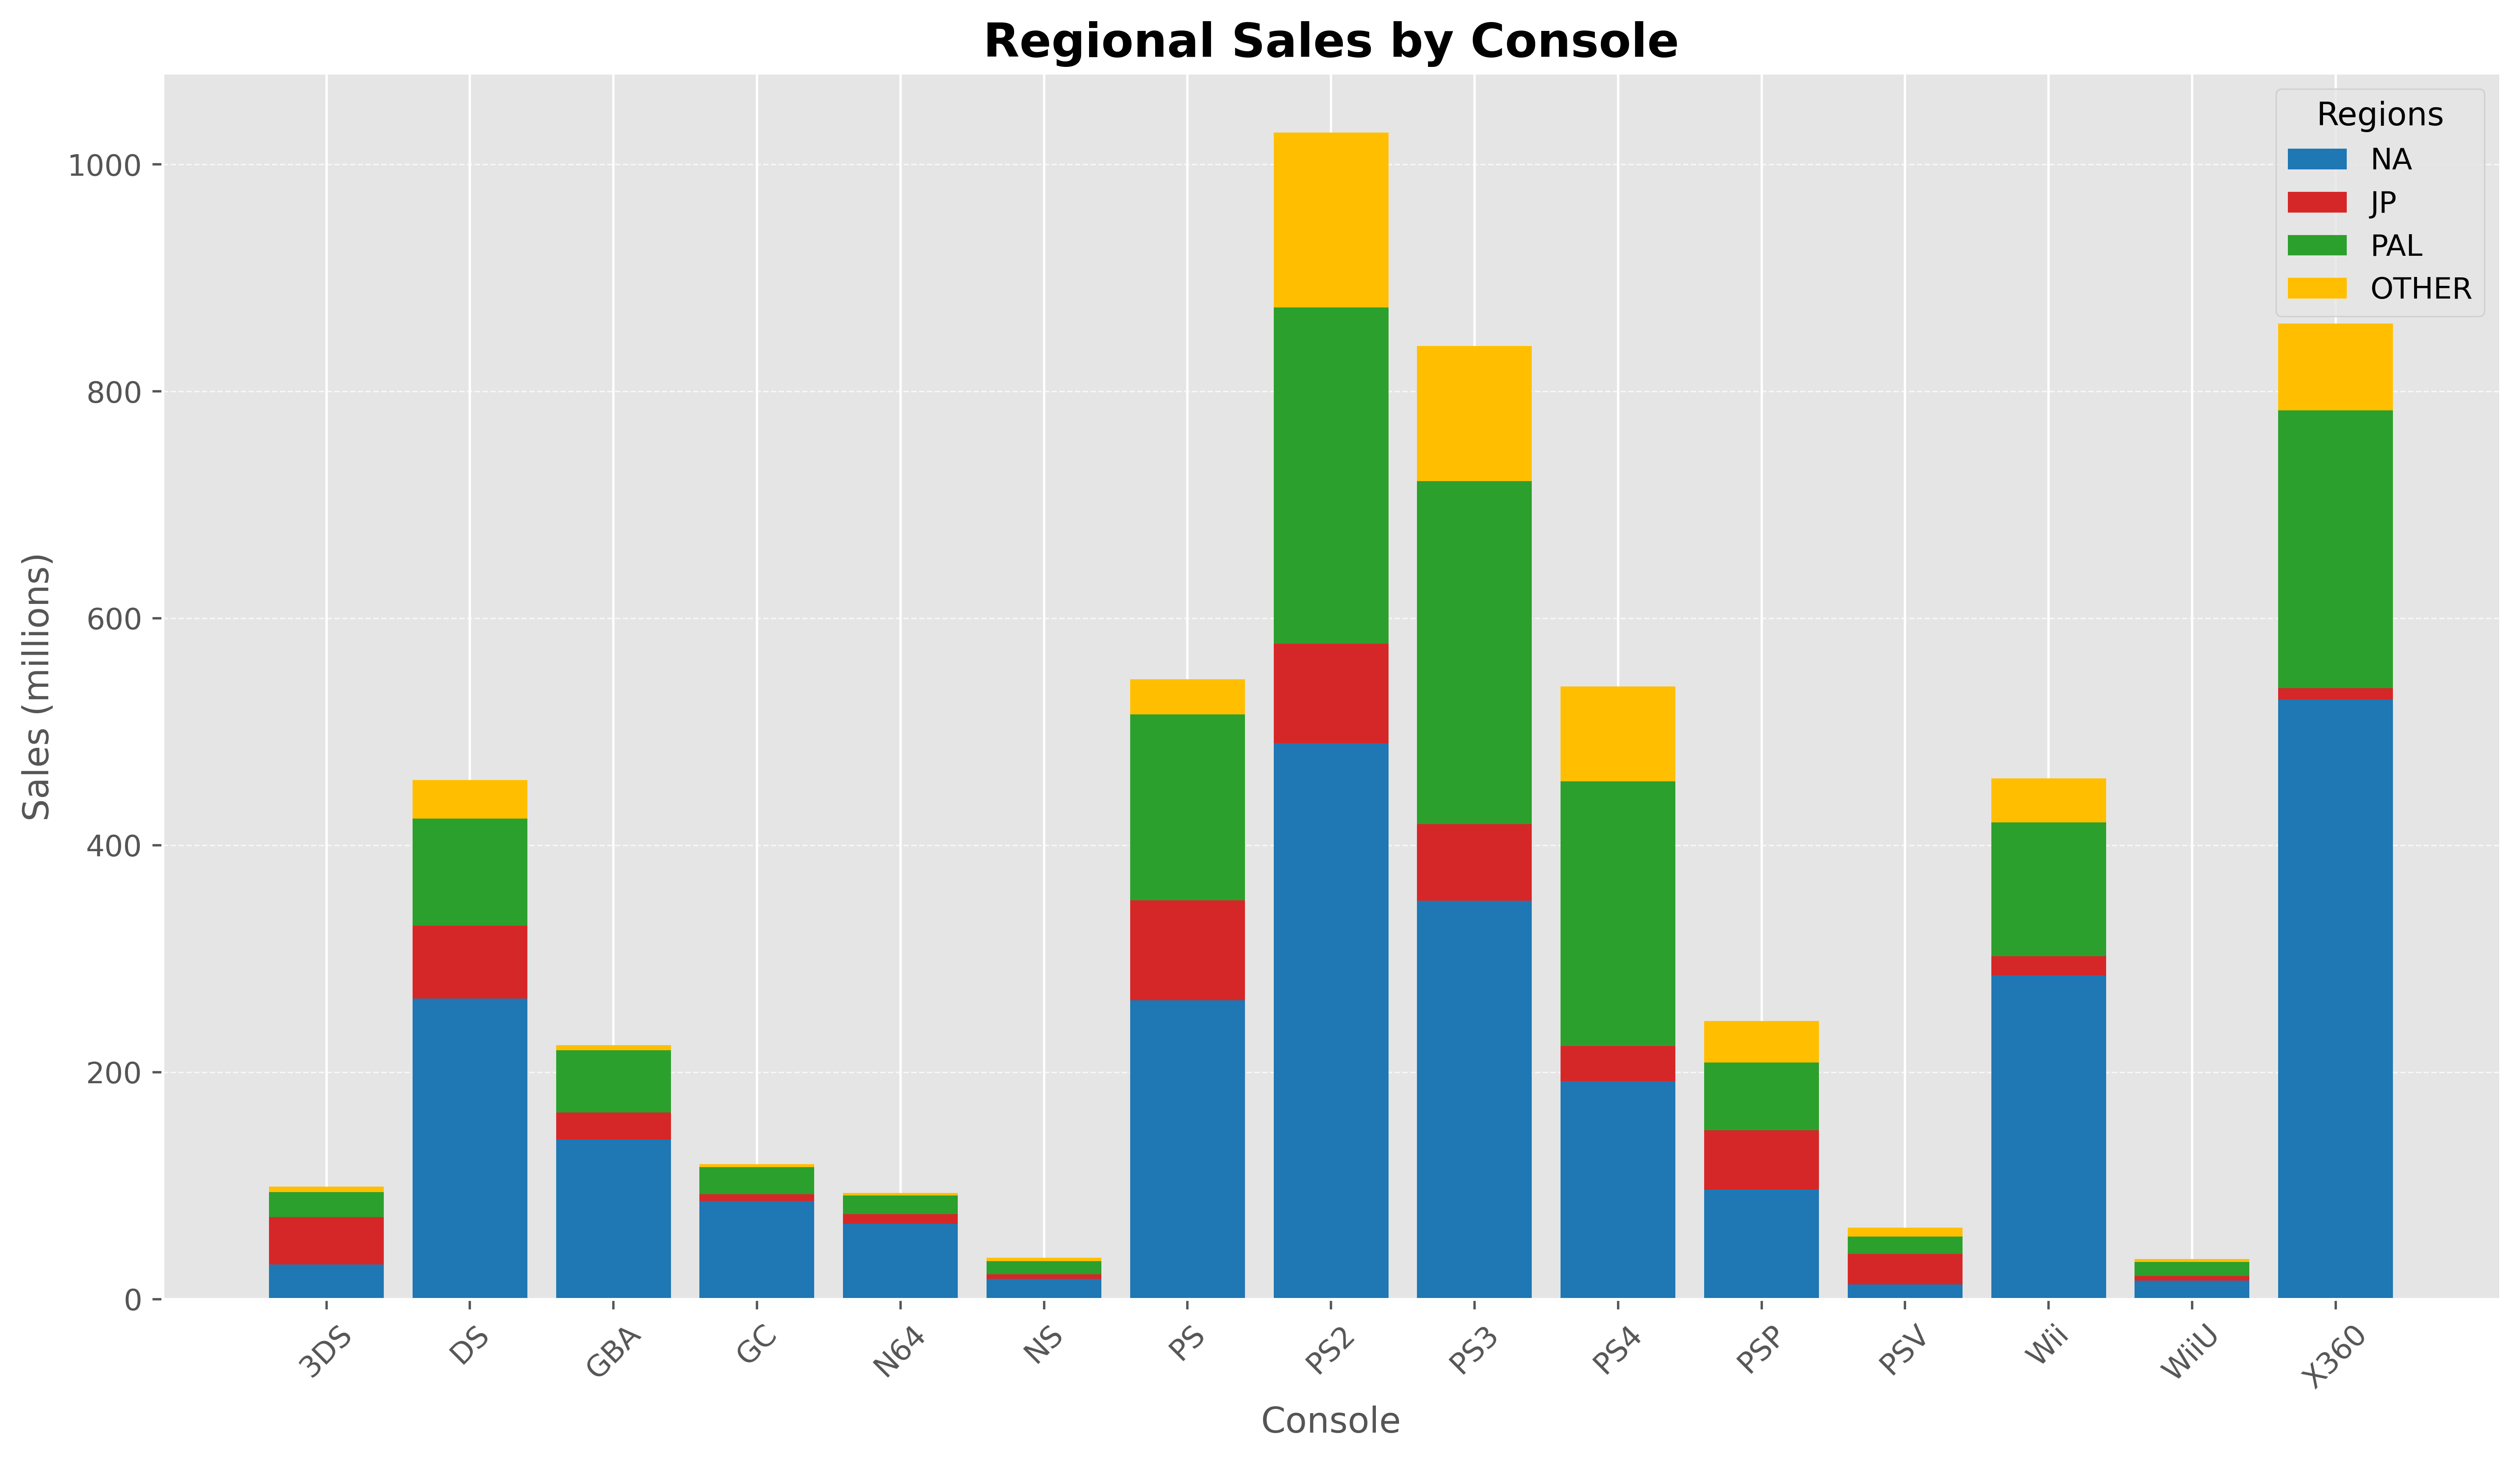

In [140]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=500, figsize=(12, 7))

# Color palette (cleaner)
colors = {
    'NA': '#1f77b4',     # blue
    'JP': '#d62728',     # red
    'PAL': '#2ca02c',    # green
    'OTHER': '#ffbf00'   # yellow-orange
}

for i in range(len(consoles)):
    na = na_sales[i]
    jp = jp_sales[i]
    pal = pal_sales[i]
    other = other_sales[i]

    ax.bar(consoles[i], na, color=colors['NA'], label='NA' if i == 0 else "")
    ax.bar(consoles[i], jp, bottom=na, color=colors['JP'], label='JP' if i == 0 else "")
    ax.bar(consoles[i], pal, bottom=na + jp, color=colors['PAL'], label='PAL' if i == 0 else "")
    ax.bar(consoles[i], other, bottom=na + jp + pal, color=colors['OTHER'], label='OTHER' if i == 0 else "")

ax.set_title("Regional Sales by Console", fontsize=16, fontweight='bold')
ax.set_ylabel("Sales (millions)", fontsize=12)
ax.set_xlabel("Console", fontsize=12)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='both', labelsize=10)

ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

ax.legend(title="Regions", fontsize=10, title_fontsize=11)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


### Critic Score vs. Sales Correlation

For all games, let's select the critic score (`critic_score`) and the total sales (`total_sales`). The idea, again, is to build a scatter plot. This is a classic scatter plot to analyze if there is a correlation between critical acclaim and commercial success. Adding a trendline would be very insightful, by the way, so I will add it too. 

In [141]:
dict_for_agg = {
    'critic_score': 'mean',
    'total_sales': 'sum'
}
critic_vs_sales = df.groupby('title').agg(dict_for_agg)
critic_vs_sales = critic_vs_sales[
    (critic_vs_sales['critic_score'] > 1 )
    &
    (critic_vs_sales['total_sales'] > 1)
]

critic_vs_sales['critic_score'] = np.round(critic_vs_sales['critic_score'], 2)
critic_vs_sales

critic_score  total_sales
title                                                         
.hack//Infection Part 1                       7.7         1.27
007: Quantum of Solace                       6.67         3.86
007: The World is Not Enough                  7.4         1.55
007: Tomorrow Never Dies                      6.2         3.21
2010 FIFA World Cup South Africa              7.4         2.97
...                                           ...          ...
Xenoblade Chronicles                         8.95         1.48
You Don't Know Jack                          7.93         1.11
Your Shape featuring Jenny McCarthy           6.0         2.16
[Prototype]                                  7.92         2.55
inFAMOUS 2                                    8.1         1.87

[879 rows x 2 columns]

In [142]:
critic_score = critic_vs_sales['critic_score'].to_list()
total_sales = critic_vs_sales['total_sales'].to_list()

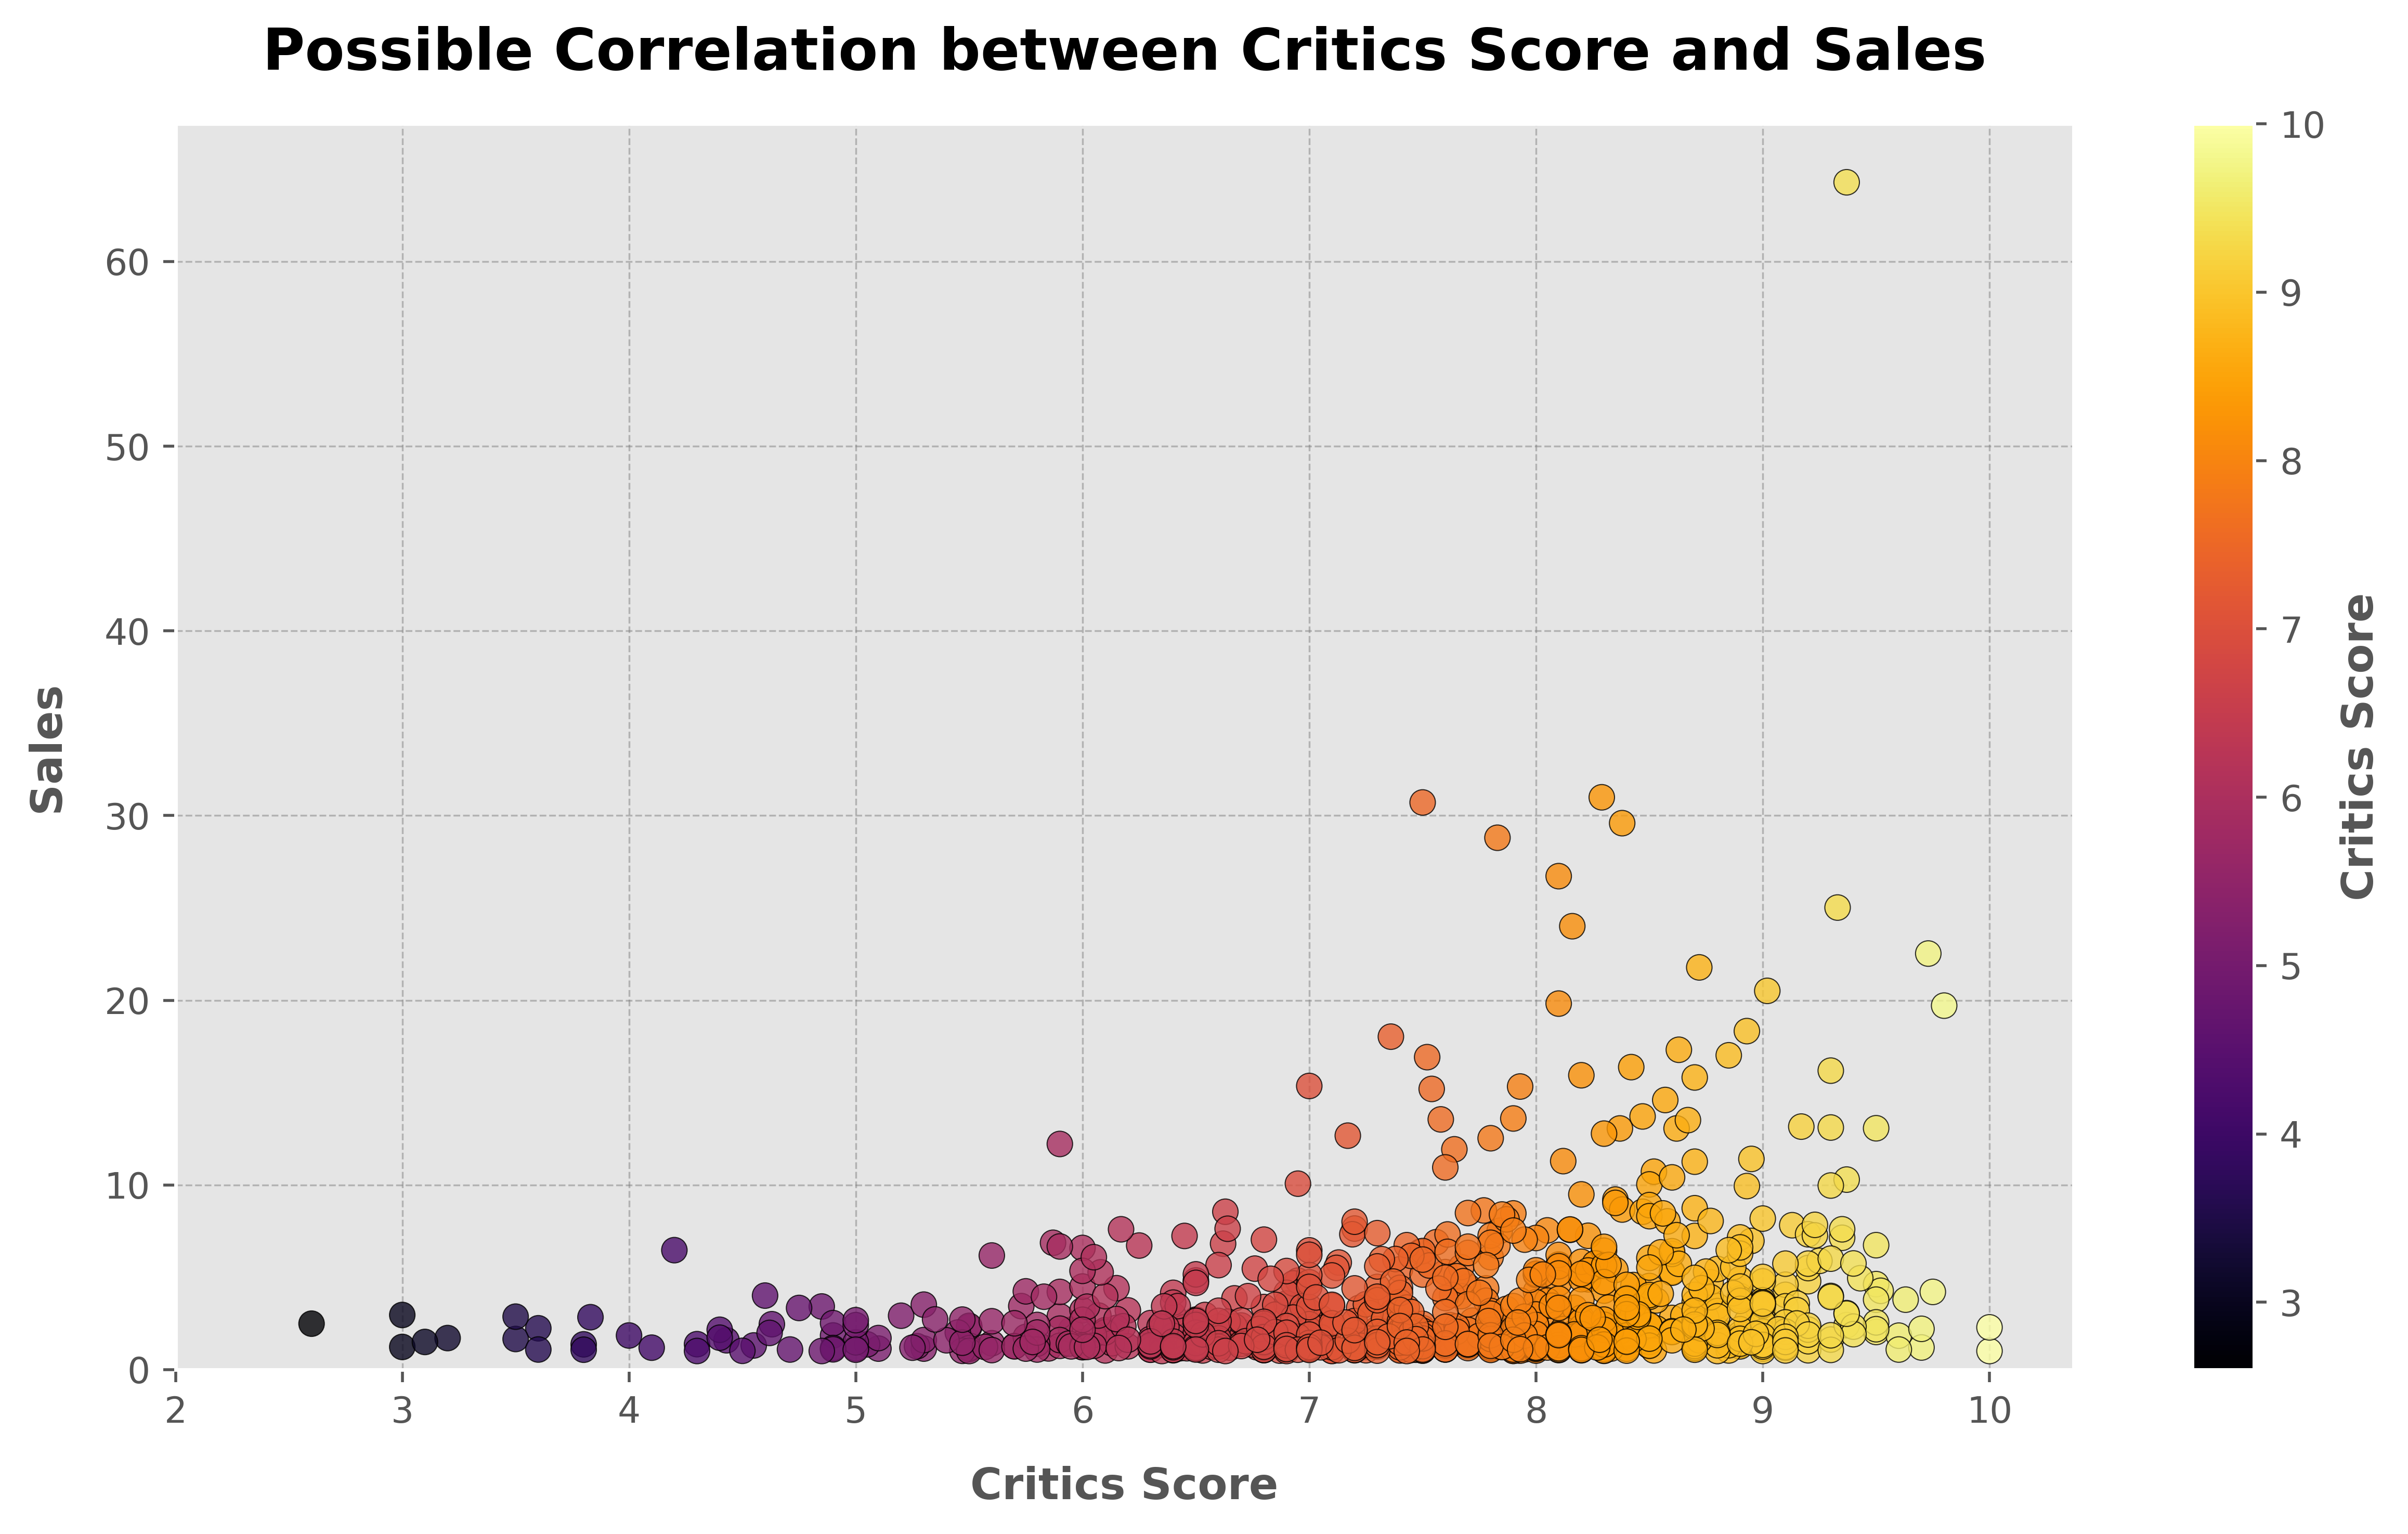

In [143]:
# Normalize critic scores for colormap mapping
norm = mcolors.Normalize(
    vmin=min(critic_score),
    vmax=max(critic_score)
)
cmap = plt.cm.inferno
colors = cmap(norm(critic_score))

fig, ax = plt.subplots(
    figsize=(10, 6),
    dpi=500
)

scatter = ax.scatter(
    critic_score,
    total_sales,
    c=colors,
    edgecolor='black',
    linewidth=0.3,
    s=50,
    alpha=0.8
)

ax.set_xlabel(
    'Critics Score',
    fontsize=12,
    fontweight='bold',
    labelpad=10
)

ax.set_ylabel(
    'Sales',
    fontsize=12,
    fontweight='bold',
    labelpad=10
)

ax.set_title(
    label='Possible Correlation between Critics Score and Sales',
    fontsize=16,
    fontweight='bold',
    color='black',
    pad=15
)

ax.grid(
    visible=True,
    which='major',
    axis='both',
    color='gray',
    linestyle='--',
    linewidth=0.5,
    alpha=0.5
)

ax.set_xlim(left=2)
ax.set_ylim(bottom=0)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Avoids warning
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(
    'Critics Score',
    fontsize=12,
    fontweight='bold'
)

plt.tight_layout()
plt.show()


### Sales Distribution by Genre

I will Calculate the total worldwide sales (total_sales) for each genre (`genre`).A treemap is an excellent way to visualize this, where the size of each rectangle represents the total sales of a genre, providing an immediate sense of market share.

In [144]:
sales_distribtuion_by_genre = df.groupby('genre') \
                                .agg({'total_sales': 'sum'}) \
                                .sort_values(by='total_sales', ascending=True)

In [145]:
total_sales = sales_distribtuion_by_genre['total_sales'].to_list()
genres = sales_distribtuion_by_genre.index.to_list()

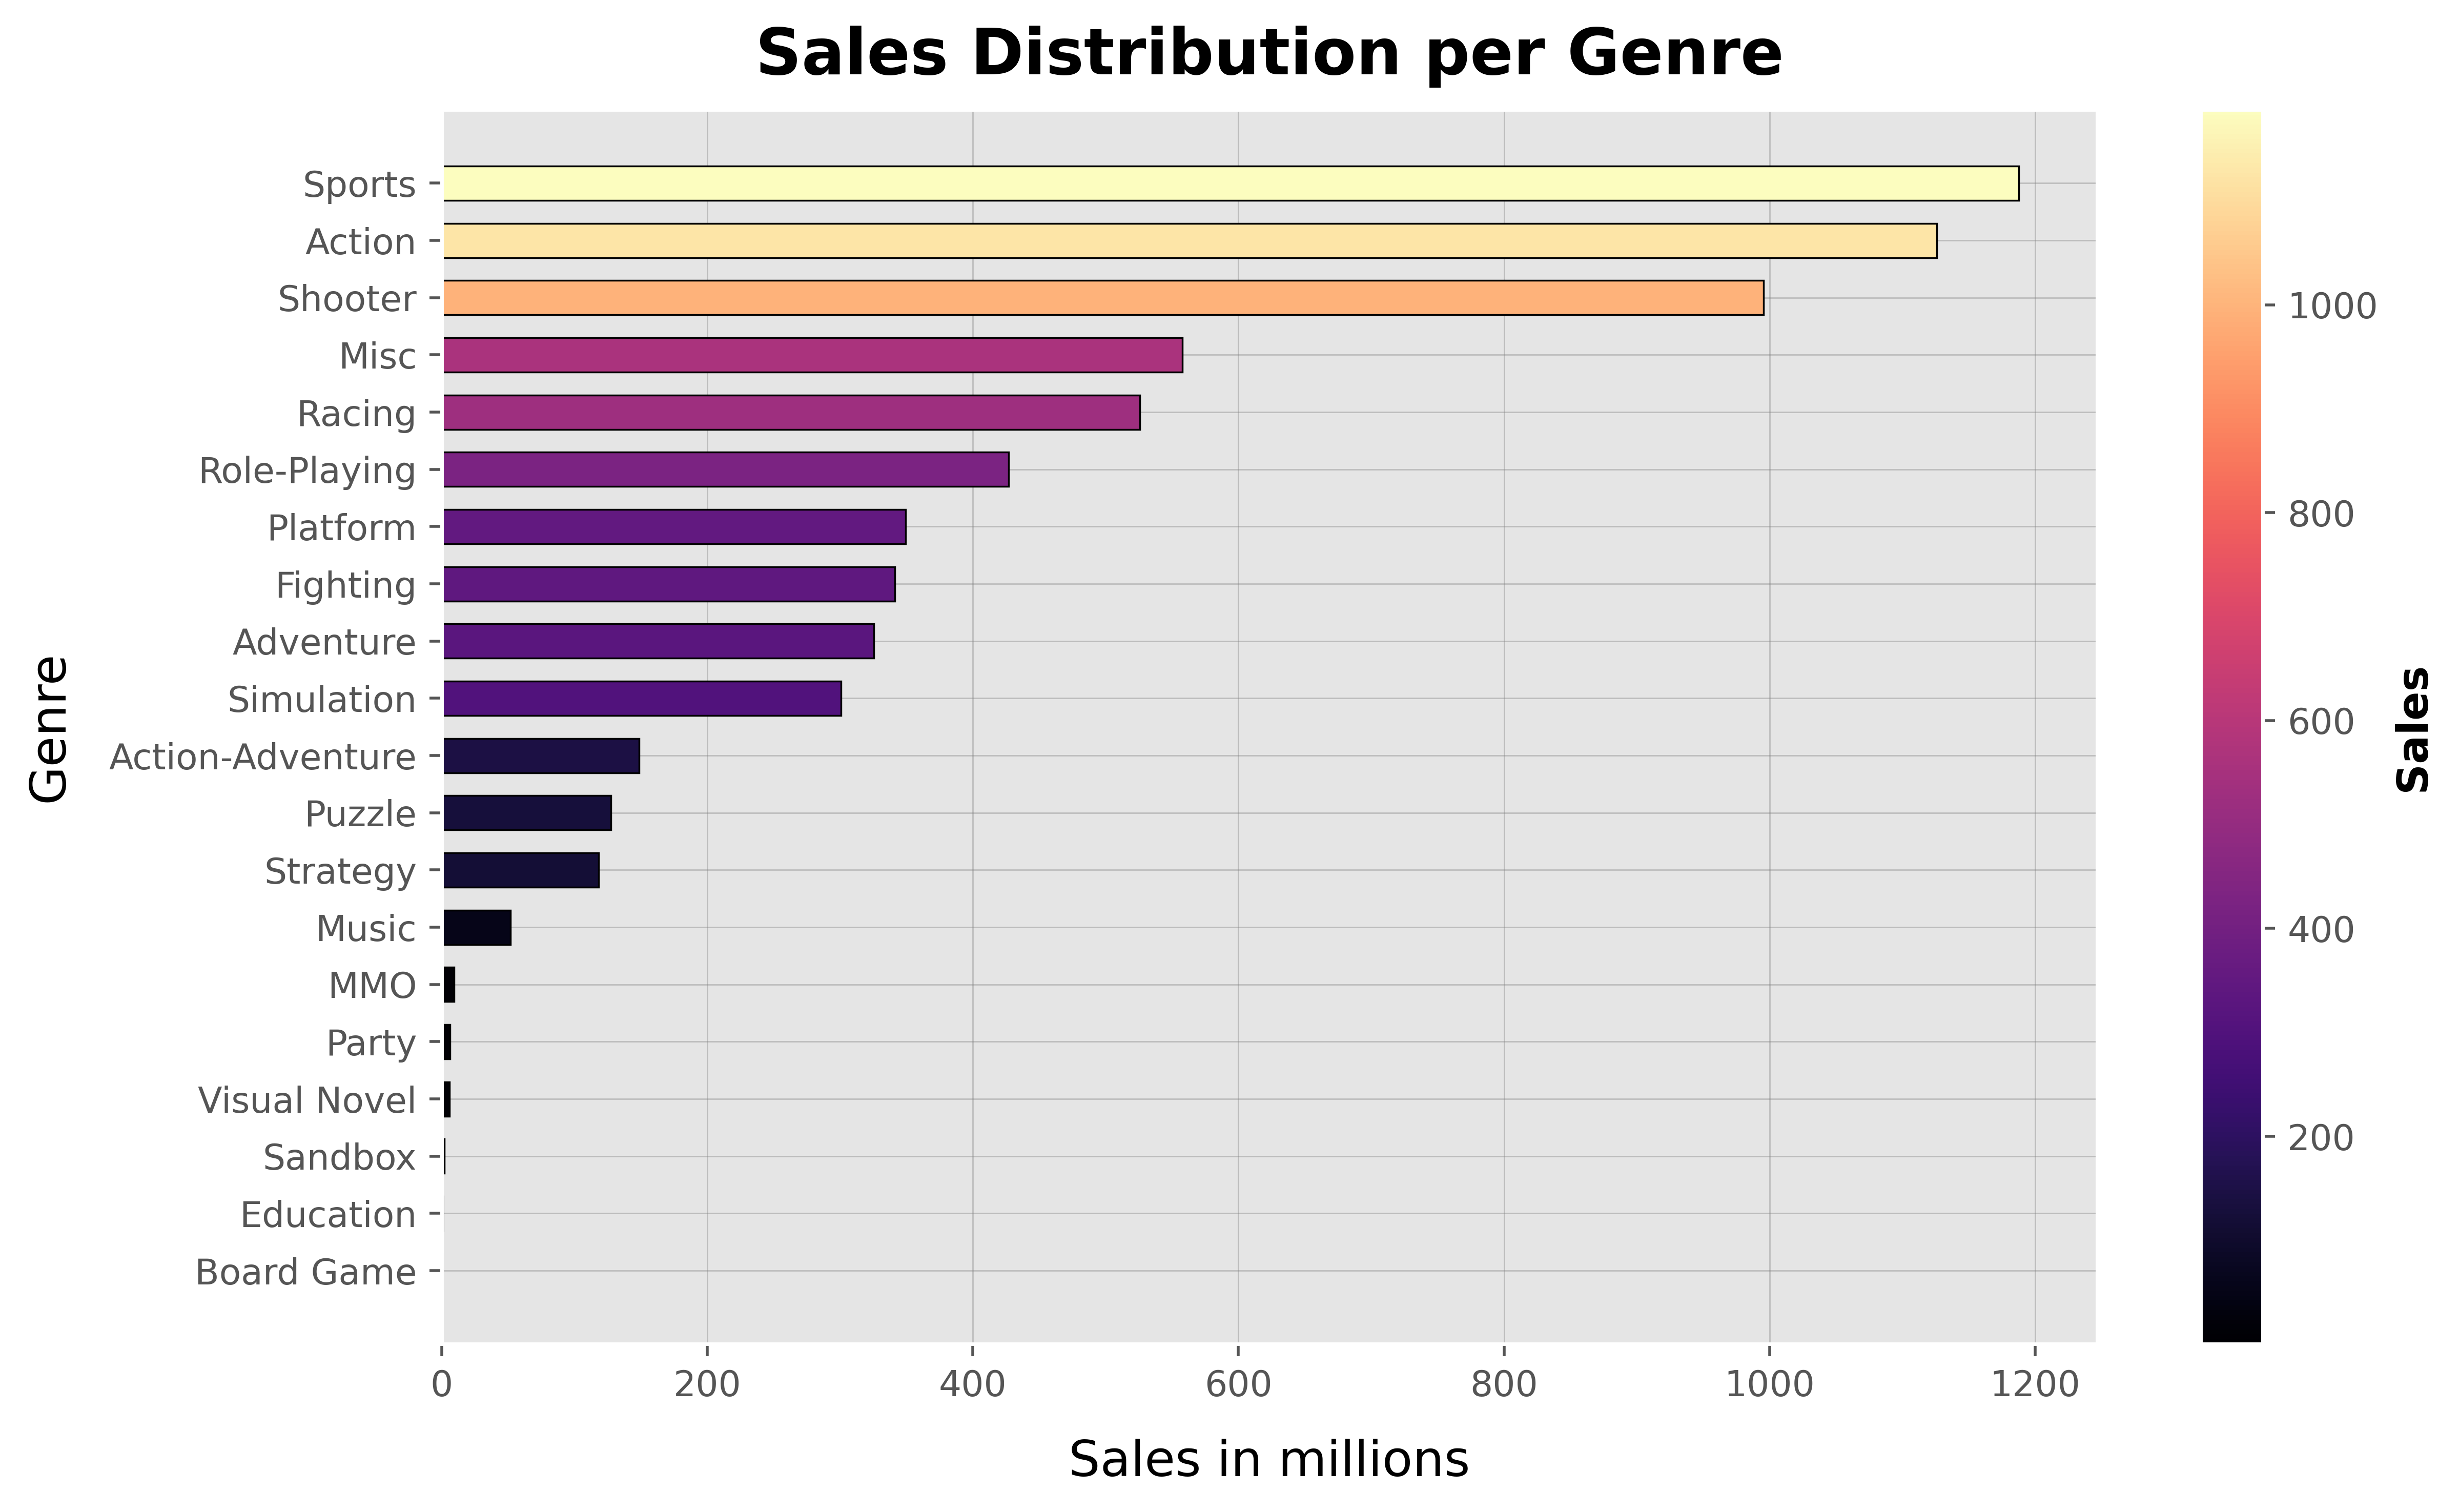

In [146]:
# Normalizing the data for colormap (0 to 1)
norm = mcolors.Normalize(
    vmin=sales_distribtuion_by_genre['total_sales'].min(),
    vmax=sales_distribtuion_by_genre['total_sales'].max()
)
cmap = plt.cm.magma
colors = cmap(norm(sales_distribtuion_by_genre['total_sales']))

fig, ax = plt.subplots(
    figsize=(10, 6),
    dpi=500,
)

ax.barh(
    y=sales_distribtuion_by_genre.index,
    width=sales_distribtuion_by_genre['total_sales'],
    height=0.6,
    color=colors,
    edgecolor='black'
)

ax.set_title(
    label='Sales Distribution per Genre',
    fontsize=18,
    fontweight='bold',
    color='black',
    loc='center',
    pad=10
)

ax.set_xlabel(
    xlabel='Sales in millions',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.set_ylabel(
    ylabel='Genre',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.grid(
    visible=True,
    which='major',
    axis='both',
    color='gray',
    linestyle='-',
    linewidth=0.4,
    alpha=0.4
)

# Adding colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(
    label='Sales',
    fontsize=12,
    fontweight='bold',
    color='black'
)

plt.tight_layout()
plt.show()

### Cumulative Sales Over Time

In [147]:
# I am going to calculate the cumulative total sales (`total_sales`) of all games
# over time, ordered by release_date.

# Before proceeding, drop NaN values.
cumulative_sales = df.dropna(subset=['total_sales', 'release_date'])

# Grouping by release year and summing up total revenue.
cumulative_sales['year'] = cumulative_sales['release_date'].dt.year
cumulative_sales = cumulative_sales.groupby('year') \
                                   .agg({'total_sales': 'sum'})

# Cumulative sum of total sales
cumulative_sales['cumulative_total_sales'] = cumulative_sales['total_sales'].cumsum()

/tmp/ipykernel_5167/4110057642.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumulative_sales['year'] = cumulative_sales['release_date'].dt.year


In [148]:
cumulative_sales.head()

total_sales  cumulative_total_sales
year                                     
1977          2.5                     2.5
1978         2.36                    4.86
1979         0.31                    5.17
1980         2.26                    7.43
1981         7.73                   15.16

In [149]:
years = cumulative_sales.index.to_list()
total_sales = cumulative_sales['total_sales'].to_list()
cumulative_sales = cumulative_sales['cumulative_total_sales'].to_list()

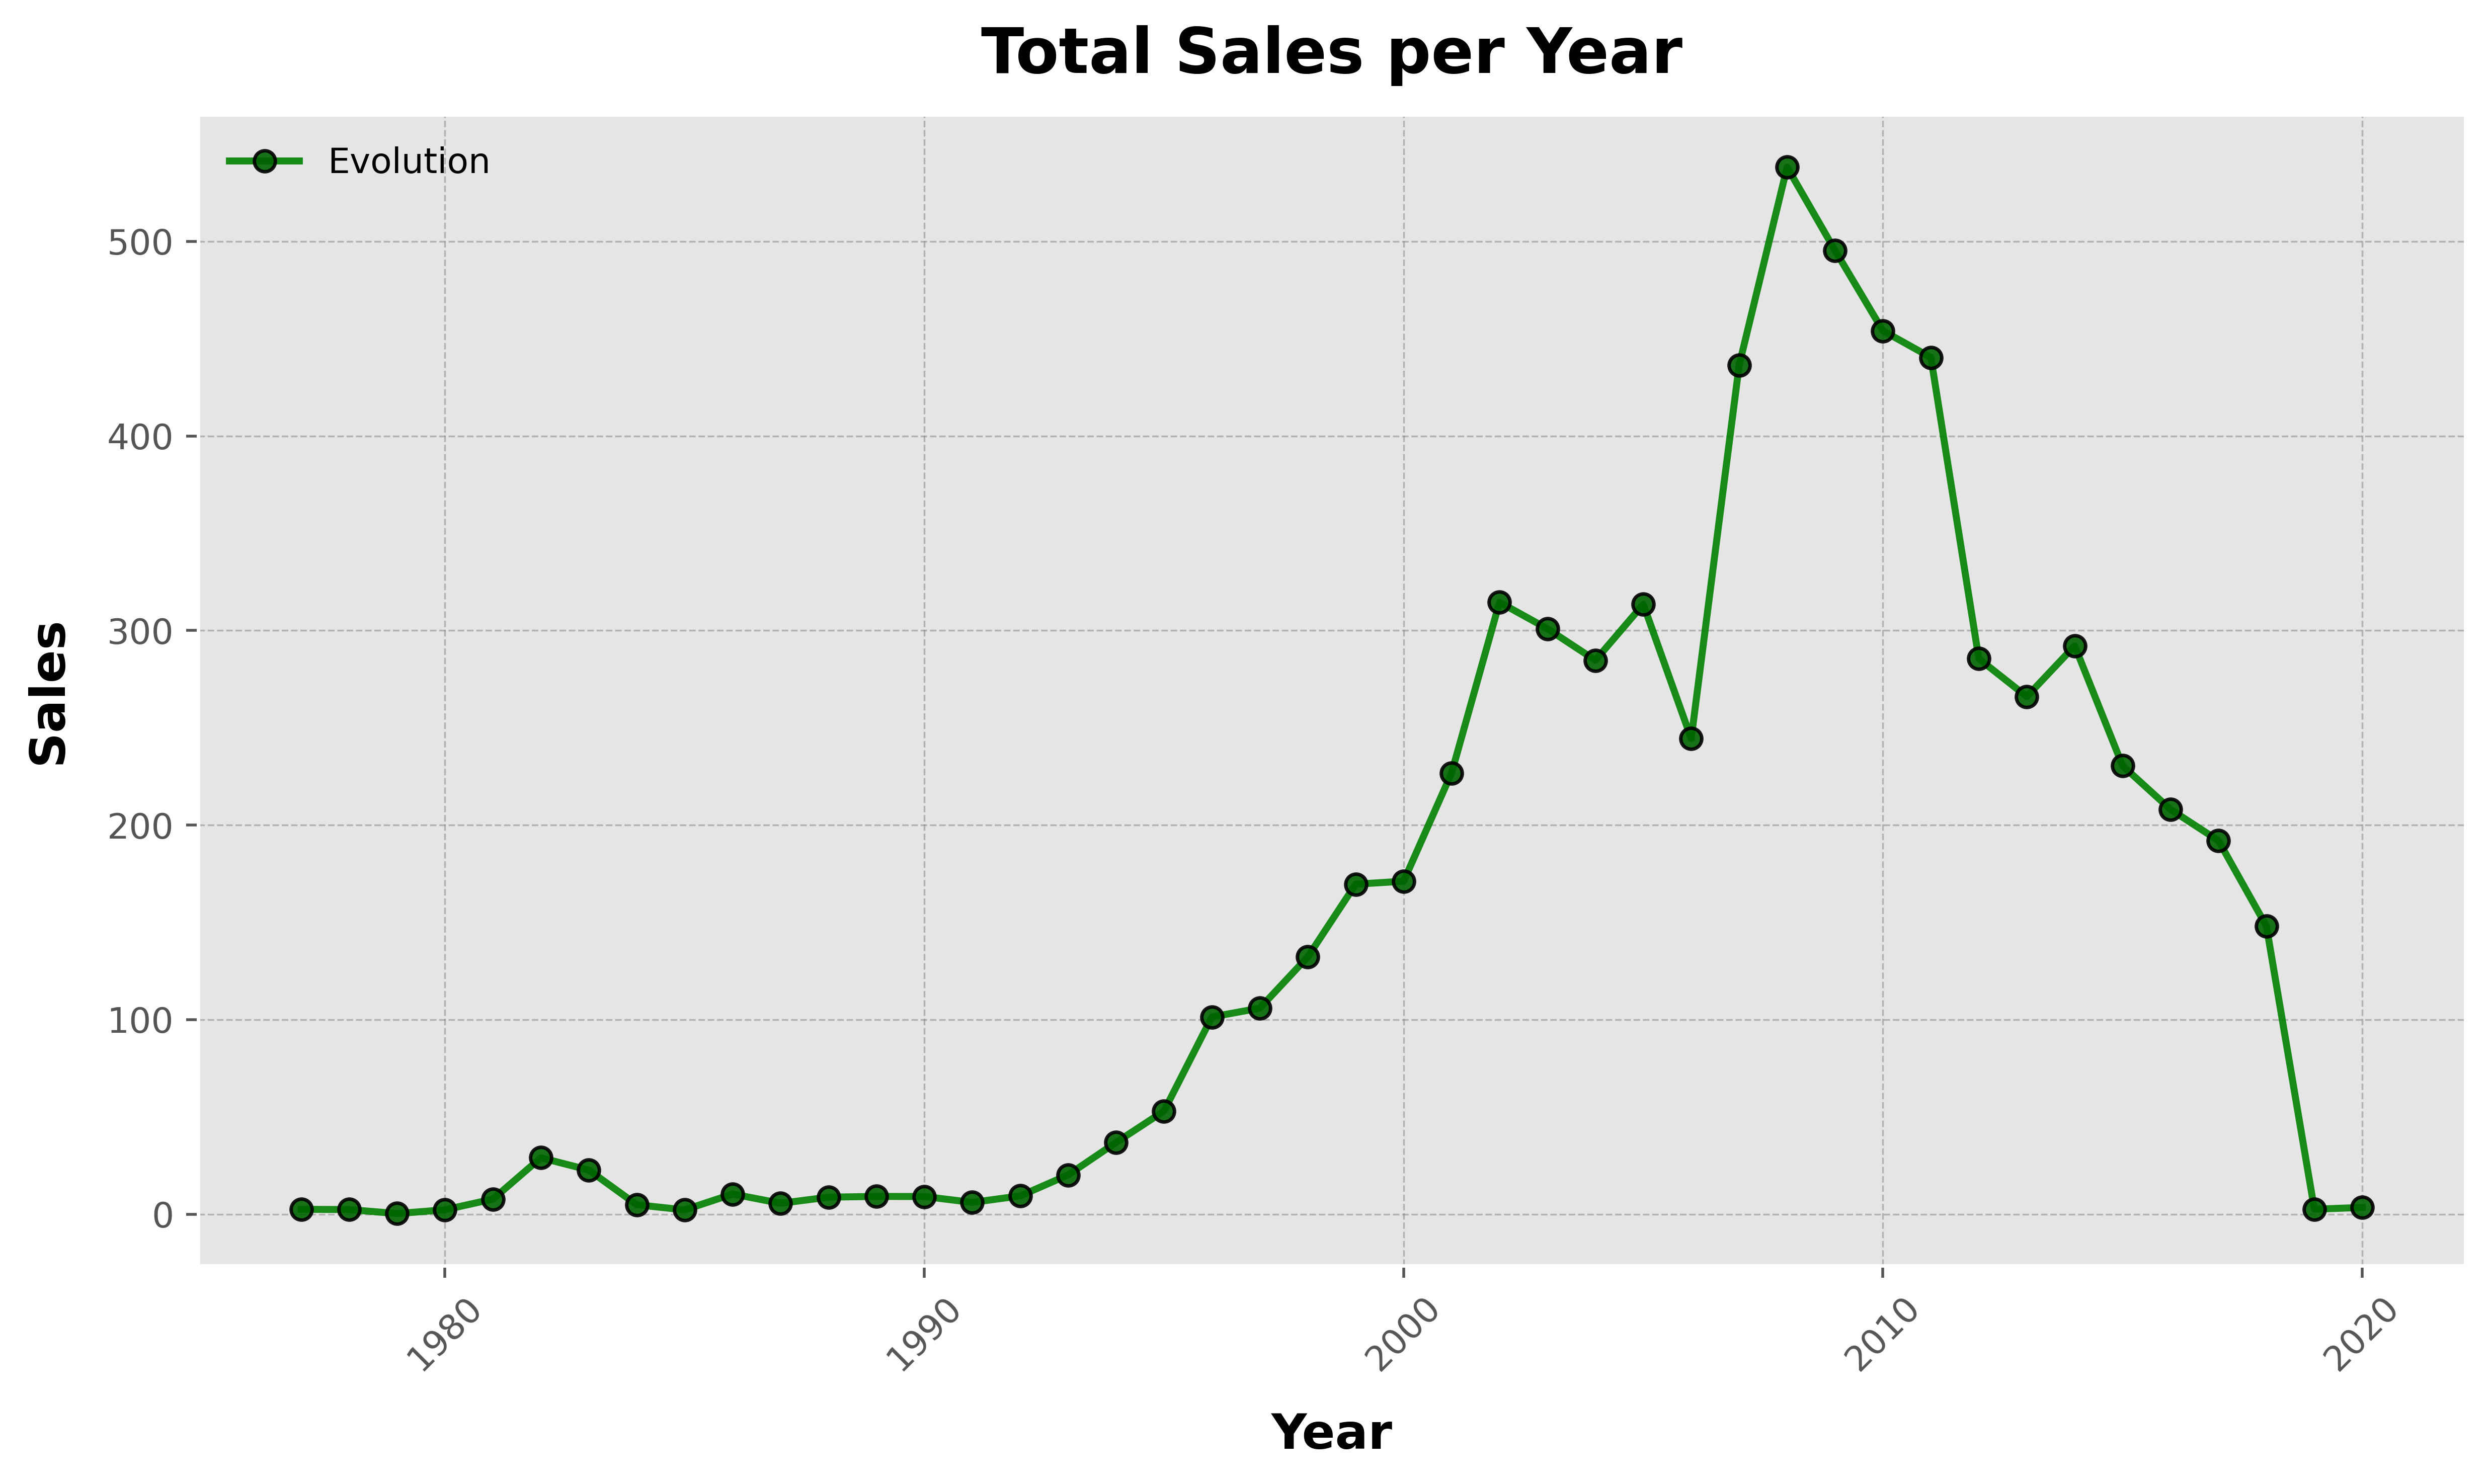

In [150]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10, 6),
    dpi=500
)

ax.plot(
    years,
    total_sales,
    color='green',
    linestyle='-',
    linewidth=2,
    marker='o',
    markersize=6,
    markerfacecolor='darkgreen',
    markeredgecolor='black',
    alpha=0.9,
    label='Evolution'
)

ax.grid(
    visible=True,
    which='major',
    axis='both',
    color='gray',
    linestyle='--',
    linewidth=0.5,
    alpha=0.5
)

ax.set_title(
    "Total Sales per Year",
    fontsize=18,
    fontweight='bold',
    color='black',
    loc='center',
    pad=12
)

ax.set_xlabel(
    "Year",
    fontsize=14,
    fontweight='bold',
    color='black',
    labelpad=10,
    loc='center'
)

ax.set_ylabel(
    "Sales",
    fontsize=14,
    fontweight='bold',
    color='black',
    labelpad=10,
    loc='center'
)

# formatting x-axis ticks to see dates. 
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

plt.xticks(rotation=45)

ax.legend(
    fontsize=10,
    loc='upper left',
    frameon=False
)

plt.tight_layout()
plt.show()


### Console Lifecycle Analysis

The idea is simple: For each console (console), I will find the year of its first game release and the year of its last game release (from `release_date`). This approximates the console's active lifecycle in the dataset. A horizontal grouped bar chart (one bar for start year, one for end year per console) effectively will shows the lifespan and era of each platform.

In [151]:
lifecycle = df.dropna(subset='release_date')

lifecycle = lifecycle.groupby('console') \
              .agg(
                  first_release=('release_date', 'min'), 
                  last_release=('release_date', 'max'))

In [152]:
# Calculationg the duration
lifecycle['duration'] = (lifecycle['last_release'] - lifecycle['first_release']).dt.days

# Picking only after 2000
lifecycle = lifecycle[lifecycle['first_release'] > '2000-01-01'] 

# Sorting for better understanding
lifecycle = lifecycle.sort_values(by='duration', ascending=True)

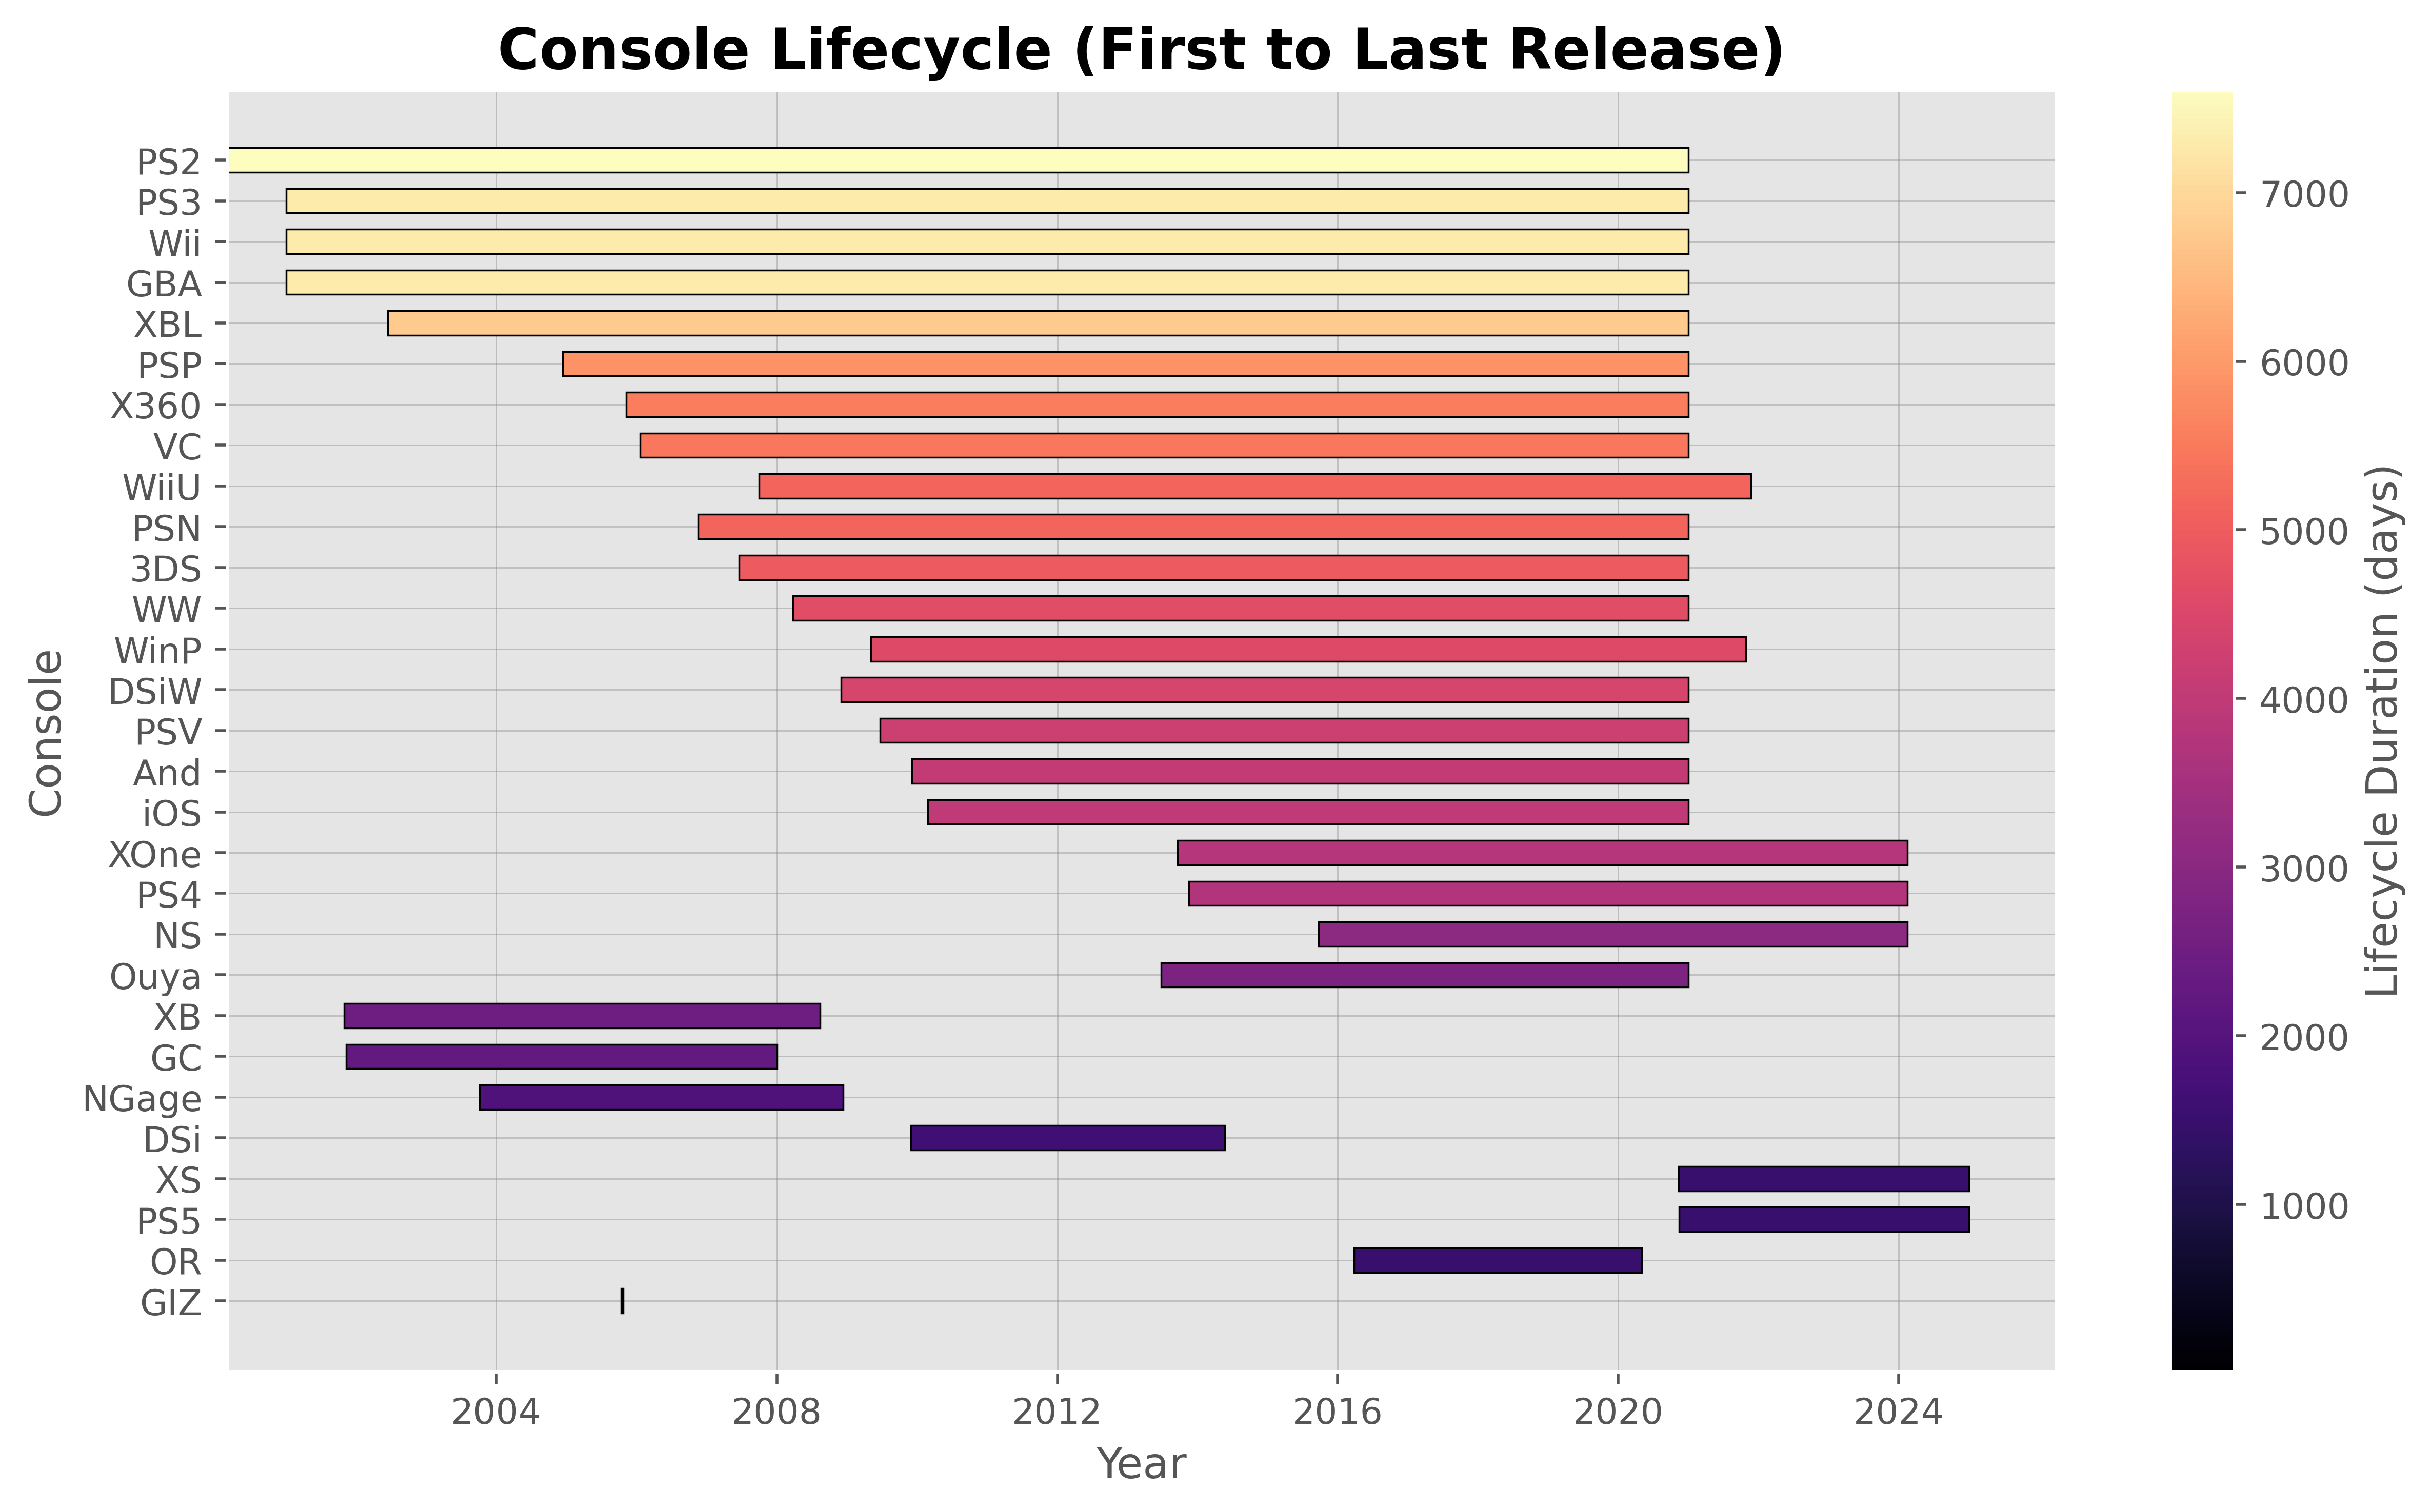

In [153]:
# Normalizing the data for colormap (0 to 1)
norm = mcolors.Normalize(
    vmin=lifecycle['duration'].min(), 
    vmax=lifecycle['duration'].max())
cmap = plt.cm.magma
colors = cmap(norm(lifecycle['duration']))

fig, ax = plt.subplots(
    figsize=(10, 6), 
    dpi=500, 
    facecolor='white'
)

ax.barh(
    y=lifecycle.index,
    width=lifecycle['duration'],
    left=lifecycle['first_release'],
    height=0.6,
    color=colors,
    edgecolor='black'
)

ax.set_xlabel('Year')
ax.set_ylabel('Console')
ax.set_title(
    label='Console Lifecycle (First to Last Release)', 
    fontsize=16, 
    fontweight='bold')

ax.grid(
    visible=True,
    which='major',
    axis='both',
    color='gray',
    linestyle='-',
    linewidth=0.4,
    alpha=0.4)

# Adding colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Lifecycle Duration (days)', fontsize=12)

plt.tight_layout()
plt.show()

### Average Critic Score by Publisher

For publishers with at least 10 games, I will calculate the average critic_score of all their games.

In [154]:
avg_critic_score_per_publisher = df.dropna(subset='critic_score') \
                                   .groupby('publisher') \
                                   .agg({'critic_score': 'mean'}) \
                                   .sort_values(by='critic_score', ascending=False)

In [155]:
avg_critic_score_per_publisher = avg_critic_score_per_publisher.sample(20)

In [156]:
avg_critic_score_per_publisher = avg_critic_score_per_publisher.sort_values(
    by='critic_score', ascending=True
)

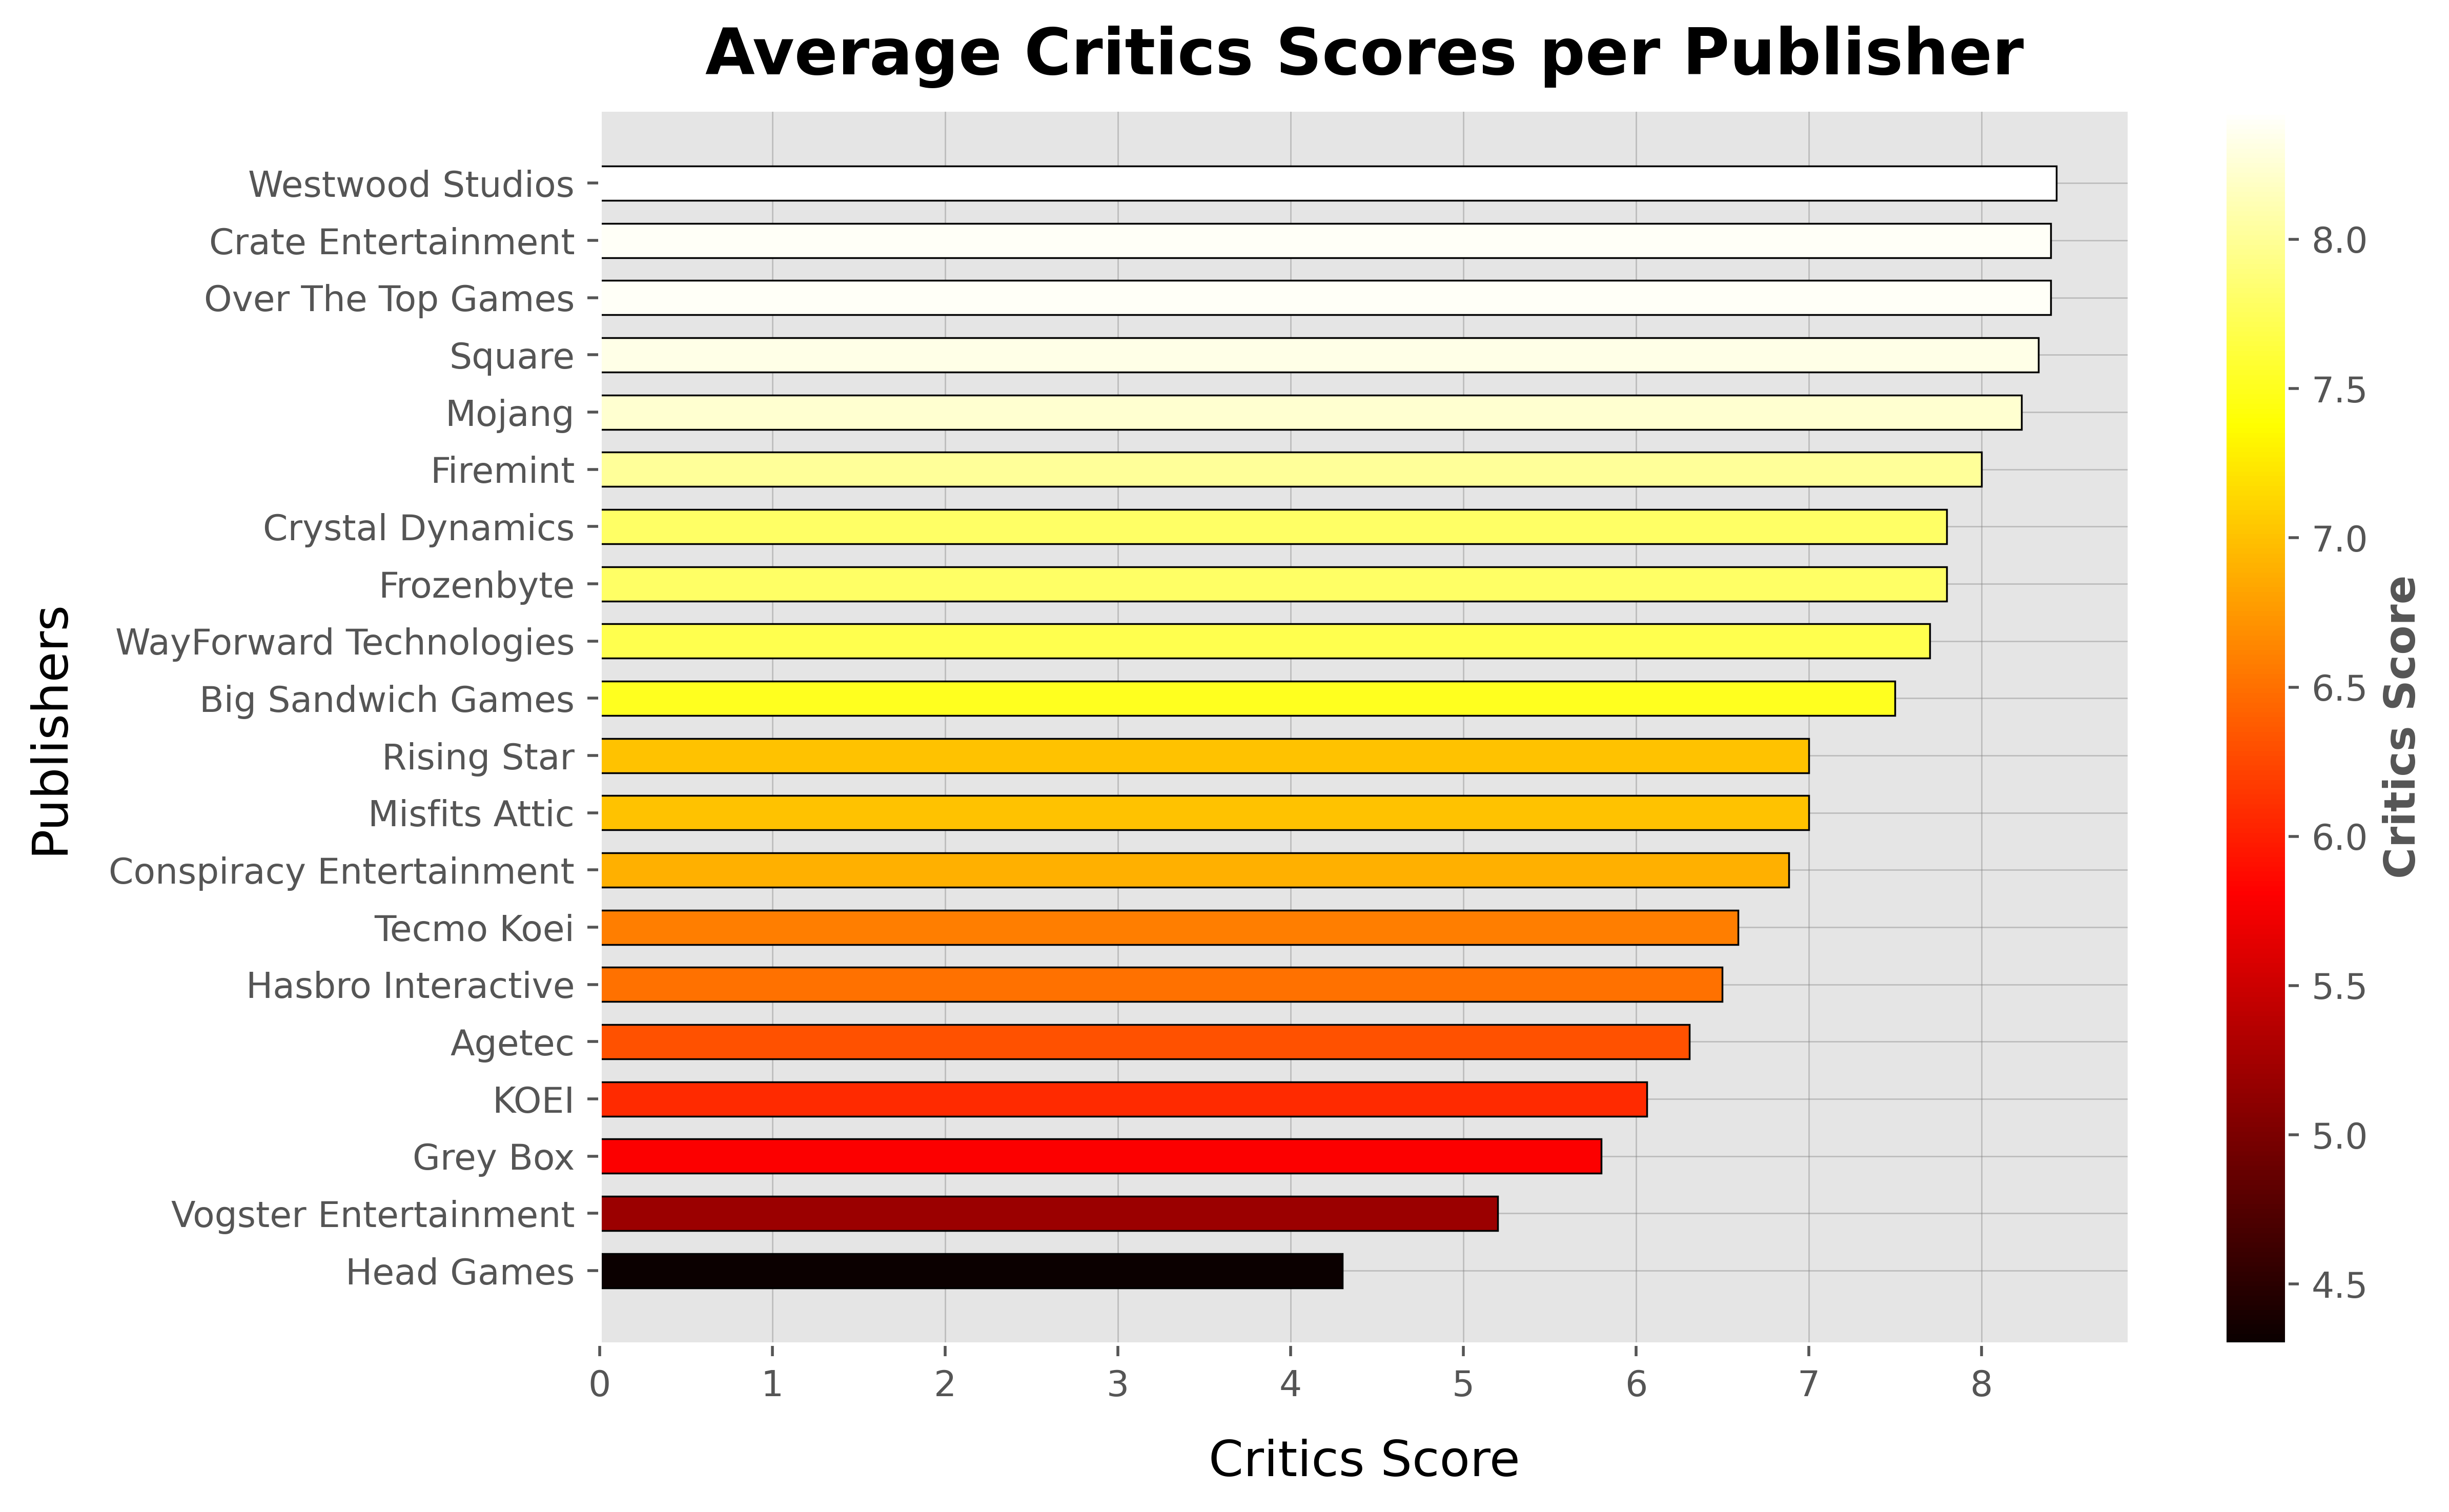

In [157]:
# Normalizing the data for colormap (0 to 1)
norm = mcolors.Normalize(
    vmin=avg_critic_score_per_publisher['critic_score'].min(),
    vmax=avg_critic_score_per_publisher['critic_score'].max()
)
cmap = plt.cm.hot
colors = cmap(norm(avg_critic_score_per_publisher['critic_score']))

fig, ax = plt.subplots(
    figsize=(10, 6),
    dpi=500,
)

ax.barh(
    y=avg_critic_score_per_publisher.index,
    width=avg_critic_score_per_publisher['critic_score'],
    height=0.6,
    color=colors,
    edgecolor='black'
)

ax.set_title(
    label='Average Critics Scores per Publisher',
    fontsize=18,
    fontweight='bold',
    color='black',
    loc='center',
    pad=10
)

ax.set_xlabel(
    xlabel='Critics Score',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.set_ylabel(
    ylabel='Publishers',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.grid(
    visible=True,
    which='major',
    axis='both',
    color='gray',
    linestyle='-',
    linewidth=0.4,
    alpha=0.4
)

# Adding colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(
    label='Critics Score',
    fontsize=12,
    fontweight='bold'
)

plt.tight_layout()
plt.show()